# Predicting the probability of stroke

The objective of this project will be to create a model that can help doctors alleviate some of the workload, by predicting whether or not a patient is in danger of suffering a stroke. A secondary objective will be to create models that can predict bmi, average glucose level and hypertension and also several of them at the same time.

## Setting up the data

First we need to import all the relevant libraries as well as set up the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
from AUS_Functions import *
import joblib

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.metrics import r2_score, recall_score, precision_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from sklearn.pipeline import Pipeline as skl_pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    OrdinalEncoder,
    OneHotEncoder,
)
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor

import statsmodels.api as sm
from autofeat import AutoFeatClassifier
from sklego.meta import Thresholder
import optuna
import shap

C:\Users\Ausmints\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Ausmints\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
sns.set()
colors = {
    "blue": "#4C72B0",
    "orange": "#DD8452",
    "green": "#55A868",
    "red": "#C44E52",
    "grey": "#8C8C8C",
}

In [4]:
data = pd.read_csv("HealthcareDatasetStrokeData.csv", index_col=0)

## EDA

Let's take a look at the data

In [5]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [7]:
data = data.rename(columns={"Residence_type": "residence_type"})

In [8]:
data.shape

(5110, 11)

In [9]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
(data["bmi"].isnull().sum() / data.shape[0]).round(2)

0.04

We can see that there are 11 columns and 5100 rows. Some features seem to be binary, some categorical and some numerical. One column contains missing values, however missing are only about 4%. 

We'll go through the features one by one to get a better understanding of the distribution of the data.

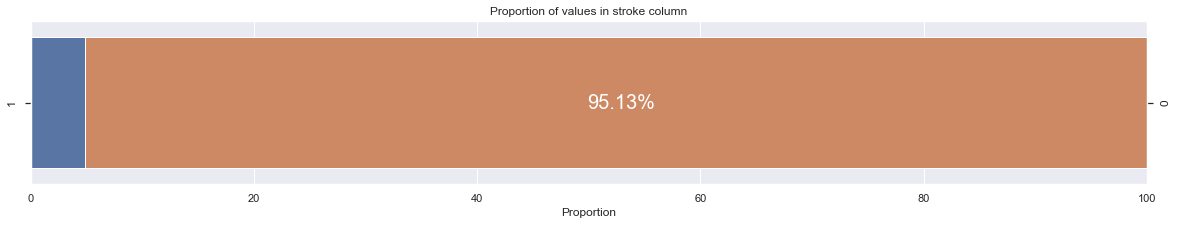

In [11]:
draw_proportion_barplot(
    data["stroke"].value_counts(),
    ["Proportion of values in stroke column", "Proportion", "", ""],
)

Target column is binary and quite unbalanced - less than 5% of the values are positive.

In [12]:
data["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [13]:
data = data.drop(data[data["gender"] == "Other"].index)

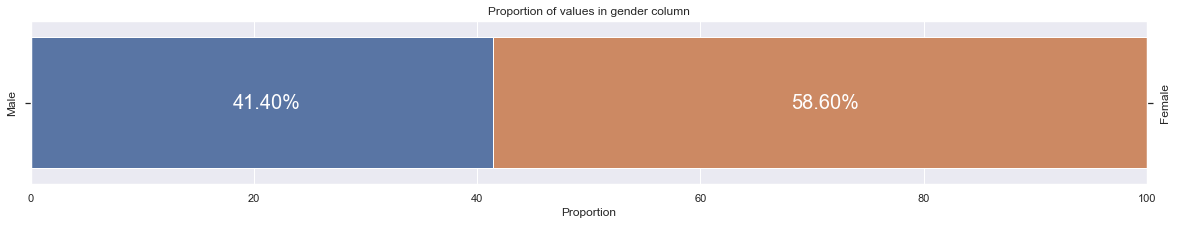

In [14]:
draw_proportion_barplot(
    data["gender"].value_counts(),
    ["Proportion of values in gender column", "Proportion", "", ""],
)

Gender feature has 3 distinct categories and only 1 row contains the "Other" category. The sample size for the category is too small to make any reasonable conclusions, so to not skew our model we will be dropping the row. However, we should keep this third category in mind and retrain the model once we have more data and a larger sample size for this category. Looking at the remaining two categories, we can see that in the dataset there are more female patients than male.

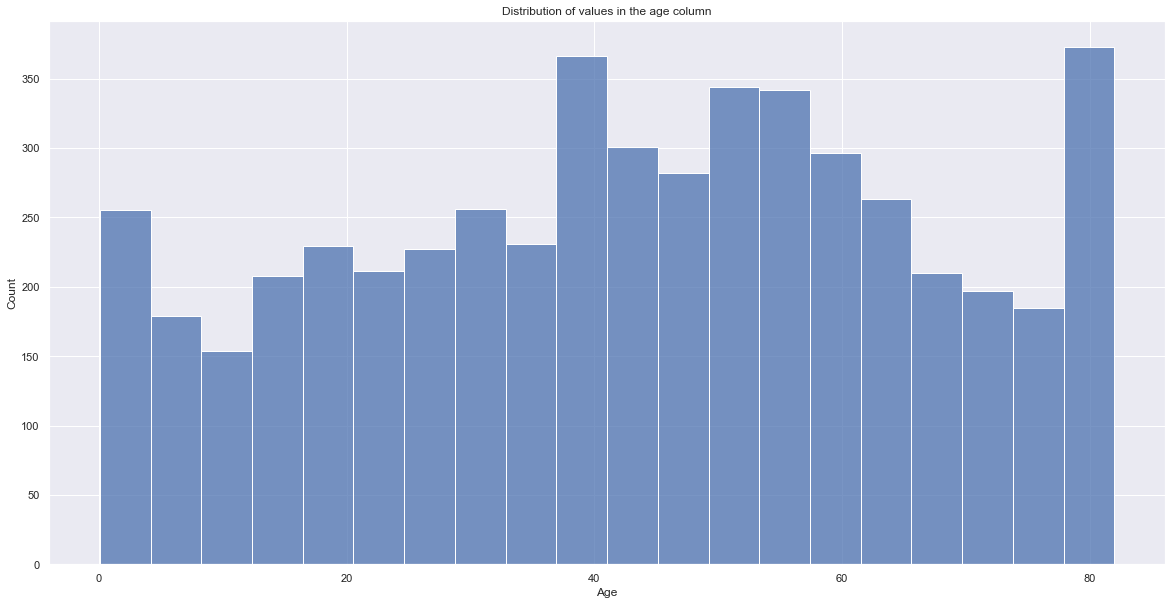

In [15]:
draw_histplot(
    data,
    "age",
    [
        "Distribution of values in the age column",
        "Age",
        "Count",
    ],
)

In [16]:
data.loc[data["age"] >= 75, "age"].value_counts()

78.0    102
79.0     85
80.0     70
81.0     60
82.0     56
75.0     53
76.0     50
77.0     42
Name: age, dtype: int64

Age feature seems to be quite uniformly distributed with a peak around age 50. There is also a spike at around 80 which is the highest bin, so it might be explained by all higher values being cropped. However if we look at all the value counts of the highest age values, we can see that the largest value counts are for ages 78 - 80 not the maximum age value 82, which would be the case if there were cropped higher values.

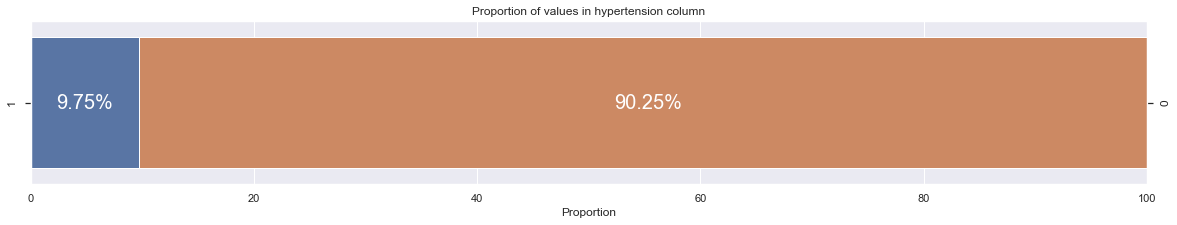

In [17]:
draw_proportion_barplot(
    data["hypertension"].value_counts(),
    ["Proportion of values in hypertension column", "Proportion", "", ""],
)

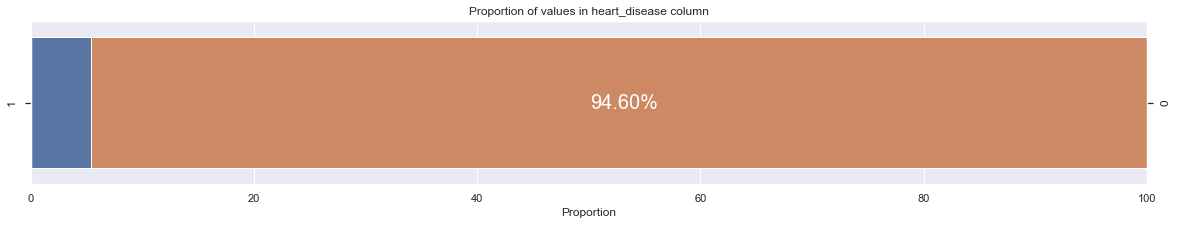

In [18]:
draw_proportion_barplot(
    data["heart_disease"].value_counts(),
    ["Proportion of values in heart_disease column", "Proportion", "", ""],
)

Hypertension and Heart disease features both are binary and heavily unbalanced with the positive values making up only a fraction of the total values. 

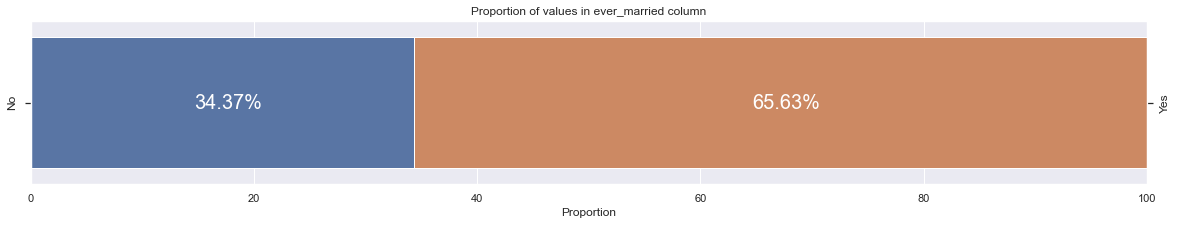

In [19]:
draw_proportion_barplot(
    data["ever_married"].value_counts(),
    ["Proportion of values in ever_married column", "Proportion", "", ""],
)

Around two thirds of the patients in dataset report having been married.

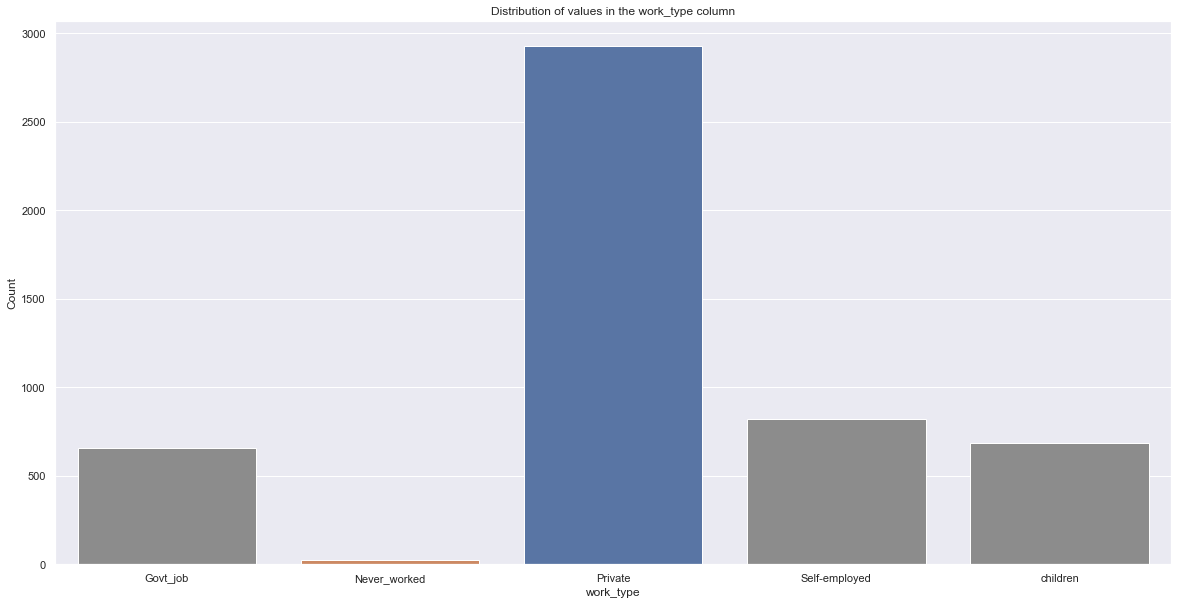

In [20]:
temp = (
    data["work_type"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"work_type": "count", "index": "work_type"})
)
draw_color_barplot(
    temp,
    "work_type",
    "count",
    "work_type",
    [
        "Distribution of values in the work_type column",
        "work_type",
        "Count",
    ],
    ["Private"],
    ["Never_worked"],
)

In [21]:
data["work_type"].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Vast majority of the patients work in private companies and only 22 of the adults have never worked anywhere.

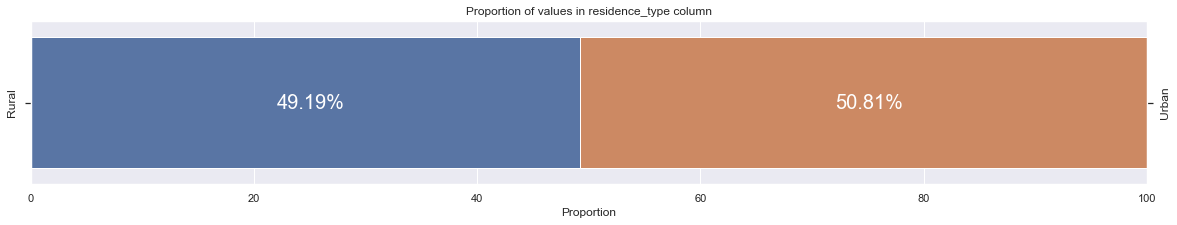

In [22]:
draw_proportion_barplot(
    data["residence_type"].value_counts(),
    ["Proportion of values in residence_type column", "Proportion", "", ""],
)

Split between rural and urban residence types seem to be balanced.

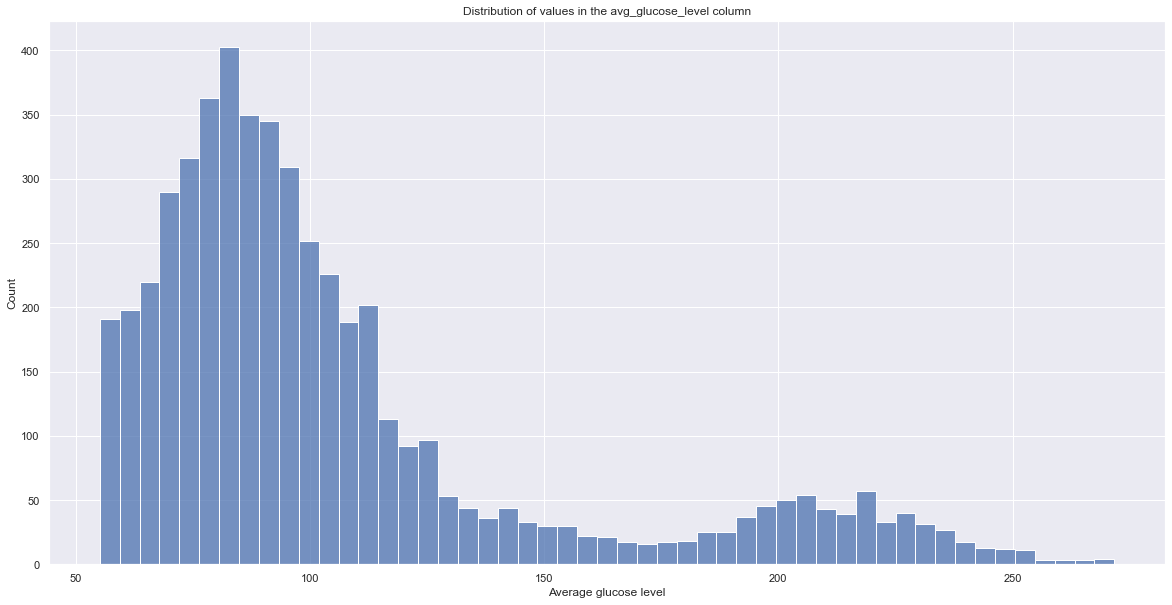

In [23]:
draw_histplot(
    data,
    "avg_glucose_level",
    [
        "Distribution of values in the avg_glucose_level column",
        "Average glucose level",
        "Count",
    ],
)

Glucose level feature seems to be quite heavily right skewed with a peak around 80. Interesting thing to notice is that there seems to be a secondary peak around 200 - 220.

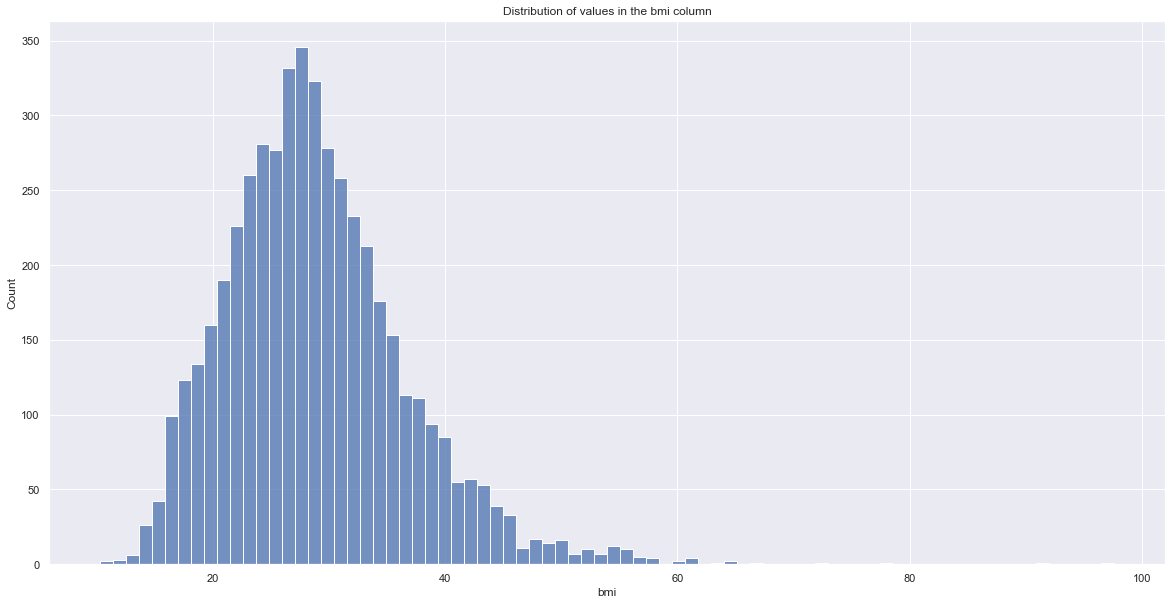

In [24]:
draw_histplot(
    data,
    "bmi",
    [
        "Distribution of values in the bmi column",
        "bmi",
        "Count",
    ],
)

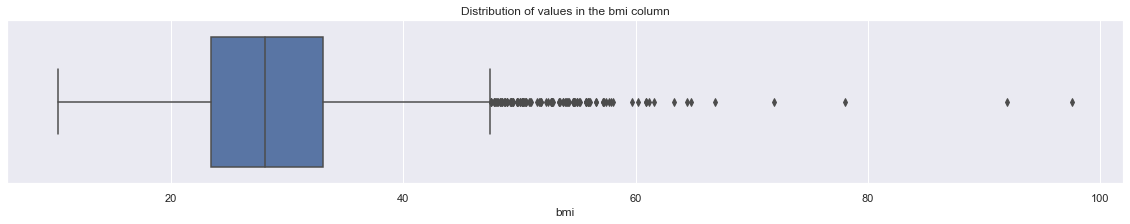

In [25]:
draw_boxplot(data, "bmi", ["Distribution of values in the bmi column", "bmi", ""])

Bmi feature seems to be normally distributed with a mean around 30 and a lot of outliers between 50 and 100.

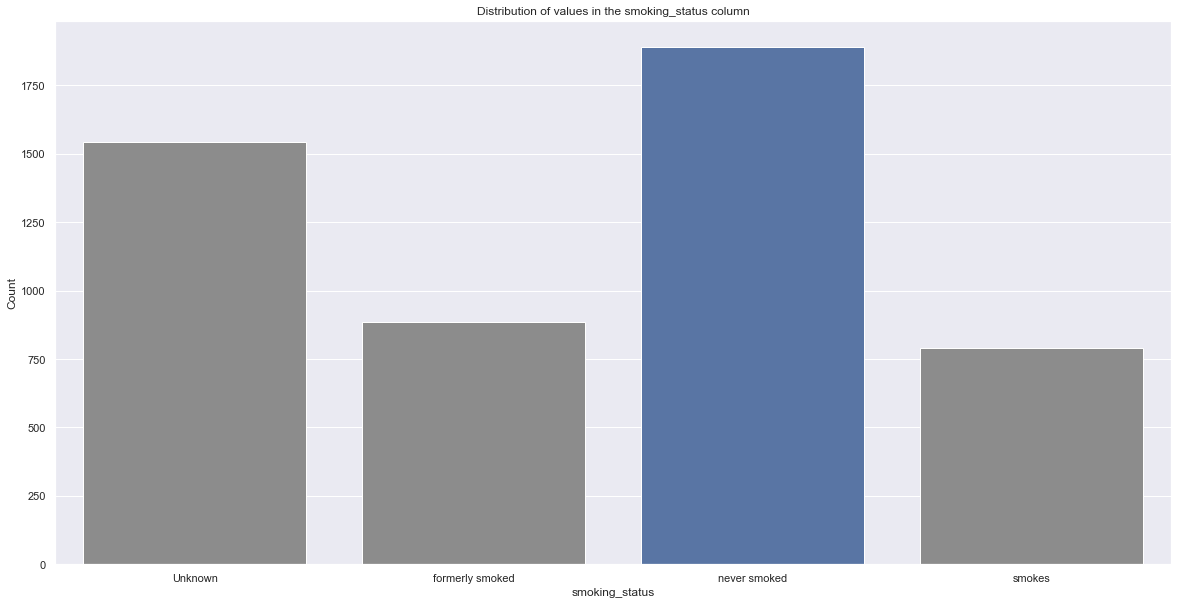

In [26]:
temp = (
    data["smoking_status"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"smoking_status": "count", "index": "smoking_status"})
)
draw_color_barplot(
    temp,
    "smoking_status",
    "count",
    "smoking_status",
    [
        "Distribution of values in the smoking_status column",
        "smoking_status",
        "Count",
    ],
    ["never smoked"],
)

In [27]:
round(data[data["smoking_status"] == "Unknown"].shape[0] / data.shape[0], 2)

0.3

Seems like around a third of the patients the answer is missing. Majority of the rest of the patients reported that they had never smoked.

Let's test some hypothesis about our target column next! 

*Considering the patients that have and those that haven't encountered stroke, does the mean age differ substantially?*

**Null hypothesis**: The mean age is similar for both patients that have had a stroke and those that have not.

**Alternative hypothesis**: The mean age is higher for patients that have had a stroke.

In [28]:
stroke_true = data.loc[data["stroke"] == 1, "age"]
stroke_false = data.loc[data["stroke"] == 0, "age"]
sm.stats.CompareMeans.from_data(stroke_false, stroke_true).ztest_ind(
    usevar="unequal", alternative="smaller"
)

(-29.68186137376657, 6.58276070014507e-194)

Unsuprisingly, age seems to be closely linked with the possibility of a stroke.

*Considering the patients that have and those that haven't encountered stroke, does the proportion of patients living in rural area differ significantly?*

**Null hypothesis**: The proportion of patients living in a rural area is similar between those that have had a stroke and those that have not.

**Alternative hypothesis**: The proportion of patients living in a rural area is smaller for patients that have had a stroke.

In [29]:
stroke_true = data.loc[data["stroke"] == 1, "residence_type"]
stroke_false = data.loc[data["stroke"] == 0, "residence_type"]
sm.stats.proportions_ztest(
    count=[stroke_false.value_counts()["Rural"], stroke_true.value_counts()["Rural"]],
    nobs=[stroke_false.shape[0], stroke_true.shape[0]],
    alternative="larger",
)

(1.10179238388168, 0.13527597110592782)

The p value is not large - 0.14, however it is not small enough for us to confidently reject the null hypothesis.

Next let's look at some of the features split by the target values. Since the categories in target column are unbalanced, we will be using proportions not actual numbers. Let's begin with age!

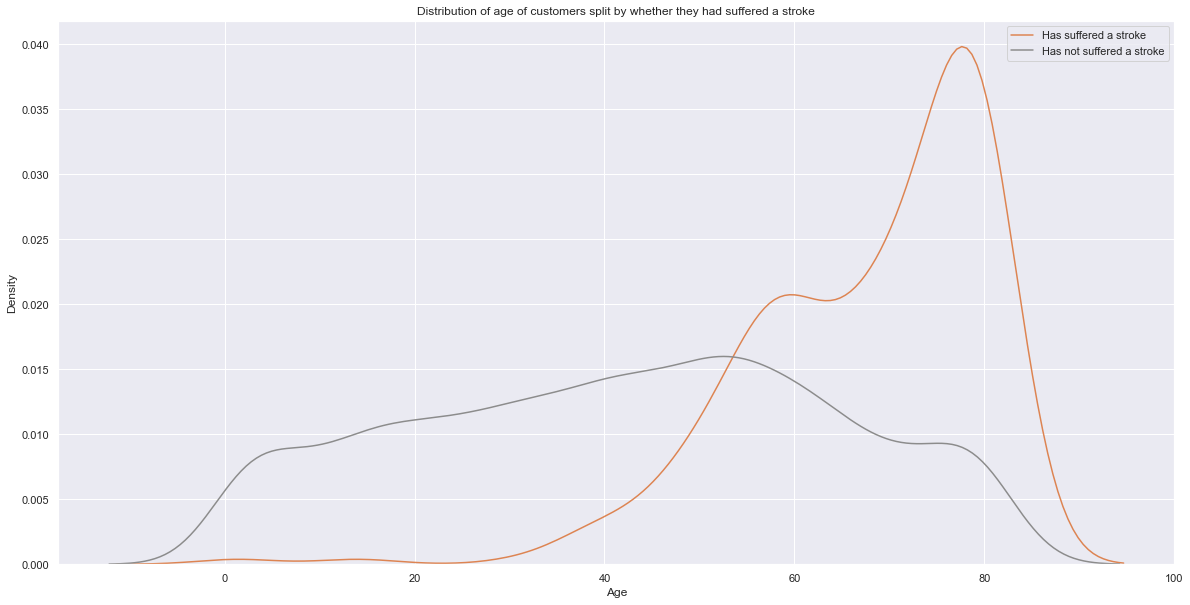

In [30]:
draw_kdeplot(
    data,
    "age",
    "stroke",
    [
        "Distribution of age of customers split by whether they had suffered a stroke",
        "Age",
        "Density",
        "Has suffered a stroke",
        "Has not suffered a stroke",
    ],
)

As we can see the distribution for patients that have not suffered a stroke is quite uniform, while the distribution for patients who have suffered a stroke is very left skewed with the peak at the max age value.

In [31]:
data[(data["stroke"] == 1) & (data["age"] < 25)]

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1


There are two entries of patients that have had stroke but have extremely low age value.

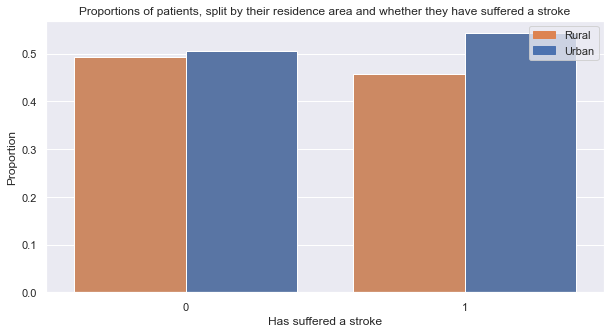

In [32]:
draw_comparison_barplot(
    data,
    "residence_type",
    "stroke",
    [],
    [
        "Proportions of patients, split by their residence area and whether they have suffered a stroke",
        "Has suffered a stroke",
        "Proportion",
        "Rural",
        "Urban",
    ],
    largefig=False,
    mode="proportion",
)

There are in total more patients from urban areas in the database, so for both groups the proportion of urban residents is larger, however the proportion of urban residents is slightly larger for patients that have suffered a stroke than for the patients that have not.

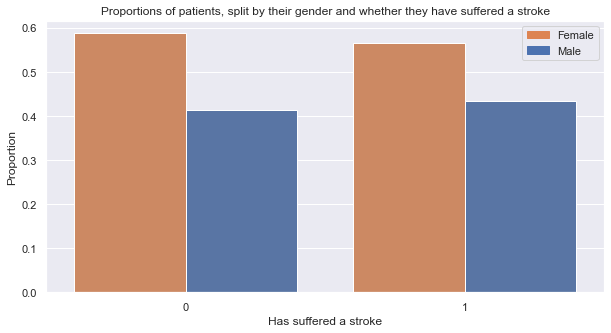

In [33]:
draw_comparison_barplot(
    data,
    "gender",
    "stroke",
    [],
    [
        "Proportions of patients, split by their gender and whether they have suffered a stroke",
        "Has suffered a stroke",
        "Proportion",
        "Female",
        "Male",
    ],
    largefig=False,
    mode="proportion",
)

We can see a slight increase in the male proportion for the patients that have suffered a stroke, comparing to those that haven't.

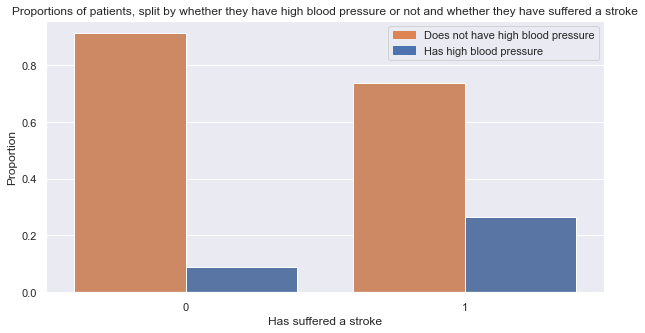

In [34]:
draw_comparison_barplot(
    data,
    "hypertension",
    "stroke",
    [],
    [
        "Proportions of patients, split by whether they have high blood pressure or not and whether they have suffered a stroke",
        "Has suffered a stroke",
        "Proportion",
        "Does not have high blood pressure",
        "Has high blood pressure",
    ],
    largefig=False,
    mode="proportion",
)

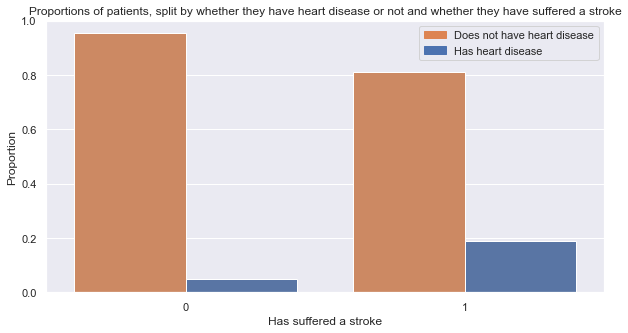

In [35]:
draw_comparison_barplot(
    data,
    "heart_disease",
    "stroke",
    [],
    [
        "Proportions of patients, split by whether they have heart disease or not and whether they have suffered a stroke",
        "Has suffered a stroke",
        "Proportion",
        "Does not have heart disease",
        "Has heart disease",
    ],
    largefig=False,
    mode="proportion",
)

While the majority of people that have suffered a stroke do not have a high blood pressure, the proportion of those that do is 3 times larger between patients that have suffered a stroke that those that haven't. For people with hearth disease, the difference in proportions is even larger.

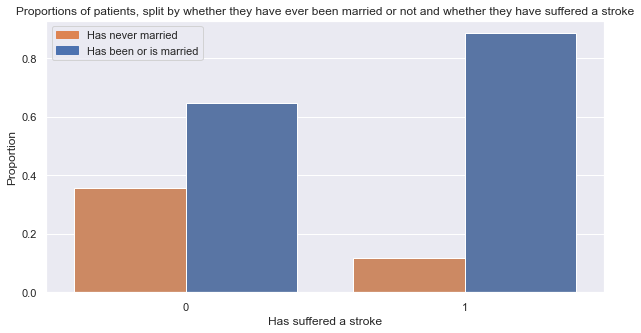

In [36]:
draw_comparison_barplot(
    data,
    "ever_married",
    "stroke",
    [],
    [
        "Proportions of patients, split by whether they have ever been married or not and whether they have suffered a stroke",
        "Has suffered a stroke",
        "Proportion",
        "Has never married",
        "Has been or is married",
    ],
    largefig=False,
    mode="proportion",
)

We can see a large difference in the proportions of whether people have suffered a stroke split on whether they have ever been married. However, we need to take into account that the proportion of people that are married decreases as the age gets smaller, as does the proportion of people that have suffered a stroke, which is almost 0 under the age of 30. So, to get a more accurate look on how important this feature is, let's look at only patients who are older than 30.

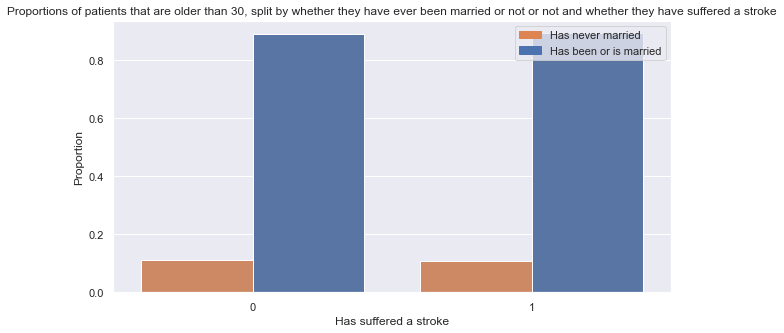

In [37]:
draw_comparison_barplot(
    data[data["age"] > 30],
    "ever_married",
    "stroke",
    [],
    [
        "Proportions of patients that are older than 30, split by whether they have ever been married or not or not and whether they have suffered a stroke",
        "Has suffered a stroke",
        "Proportion",
        "Has never married",
        "Has been or is married",
    ],
    largefig=False,
    mode="proportion",
)

And we can see that for this age range, where the question about marriage is more appropriate and most of the variation correlating to age has been taken away, the distributions look approximately the same.

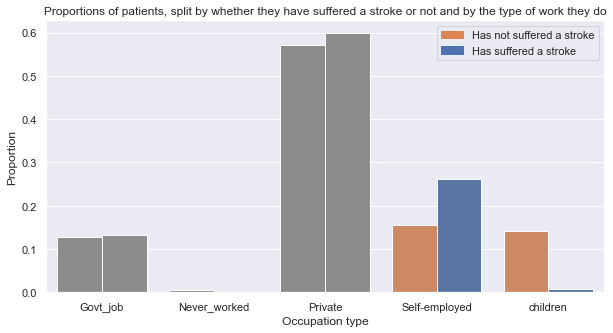

In [38]:
draw_comparison_barplot(
    data,
    "stroke",
    "work_type",
    ["Self-employed", "children"],
    [
        "Proportions of patients, split by whether they have suffered a stroke or not and by the type of work they do",
        "Occupation type",
        "Proportion",
        "Has not suffered a stroke",
        "Has suffered a stroke",
    ],
    largefig=False,
    mode="proportion",
)

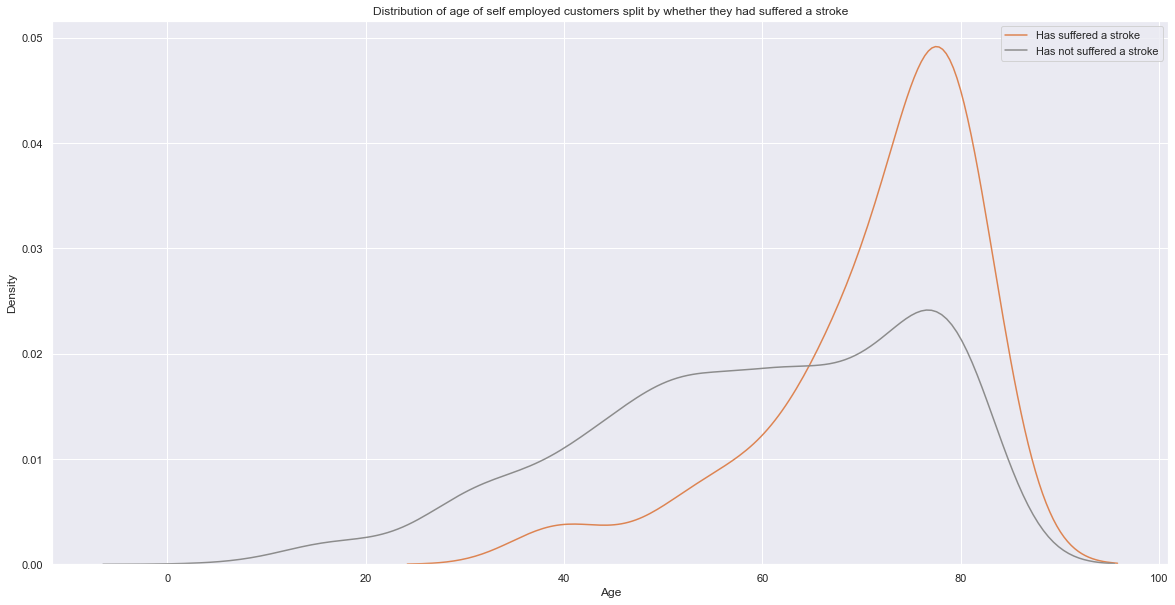

In [39]:
draw_kdeplot(
    data[data["work_type"] == "Self-employed"],
    "age",
    "stroke",
    [
        "Distribution of age of self employed customers split by whether they had suffered a stroke",
        "Age",
        "Density",
        "Has suffered a stroke",
        "Has not suffered a stroke",
    ],
)

If we look at the work type for the patients, we can see, that the proportions for people in private field and governement job is quite close, while for self-employed the distribution seems to be skewed.

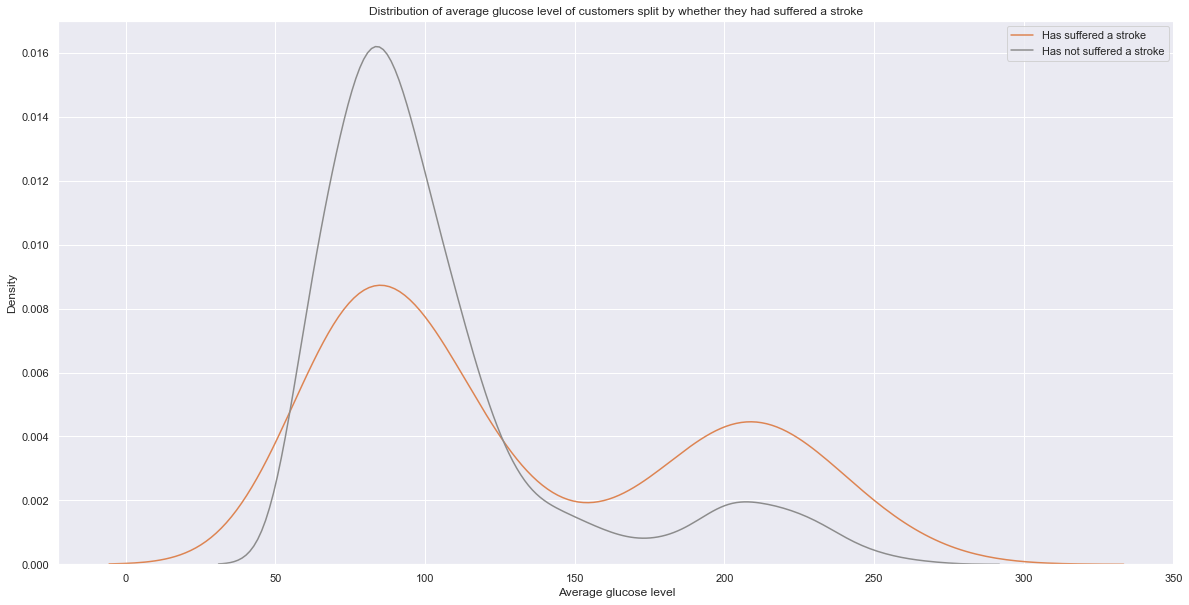

In [40]:
draw_kdeplot(
    data,
    "avg_glucose_level",
    "stroke",
    [
        "Distribution of average glucose level of customers split by whether they had suffered a stroke",
        "Average glucose level",
        "Density",
        "Has suffered a stroke",
        "Has not suffered a stroke",
    ],
)

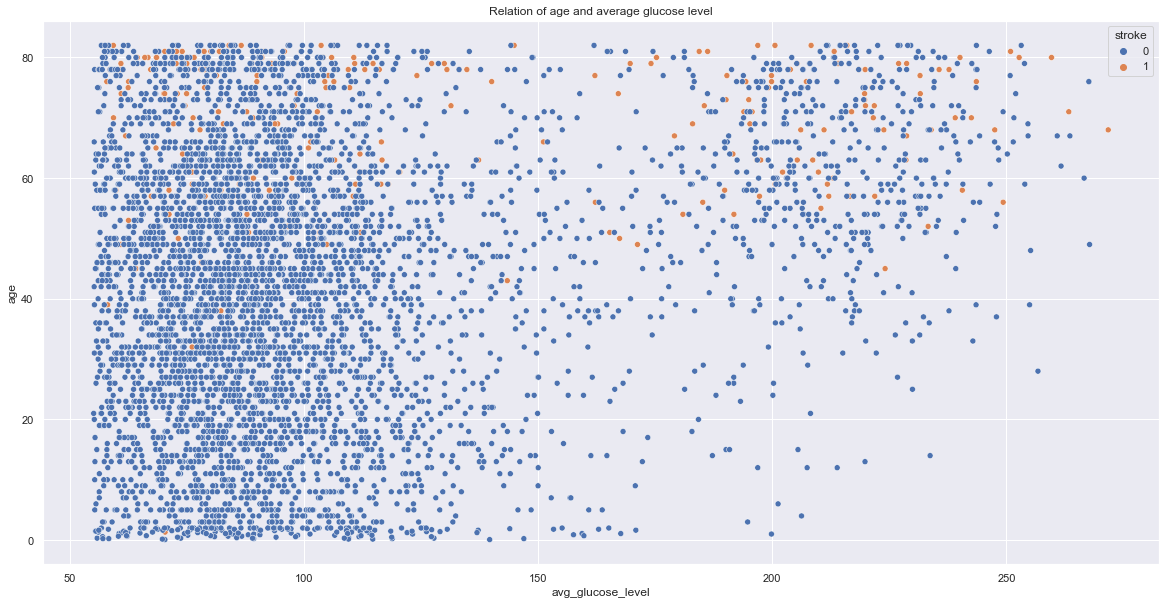

In [41]:
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(data=data, y="age", x="avg_glucose_level", hue="stroke")
ax.set_title("Relation of age and average glucose level")
plt.show()

In the distribution of average glucose level values we can see two peaks. The distribution density is different between stroke patients and others - while both distributions have two peaks, and both distributions have a larger proportion of values in the lowest peak, there is a lot larger proportion of stroke patients in the higher peak than there is for non stroke patients.
Also, as we can see, the average glucose level does seem to be higher for older people, so again age might explain some of the differences in distributions.

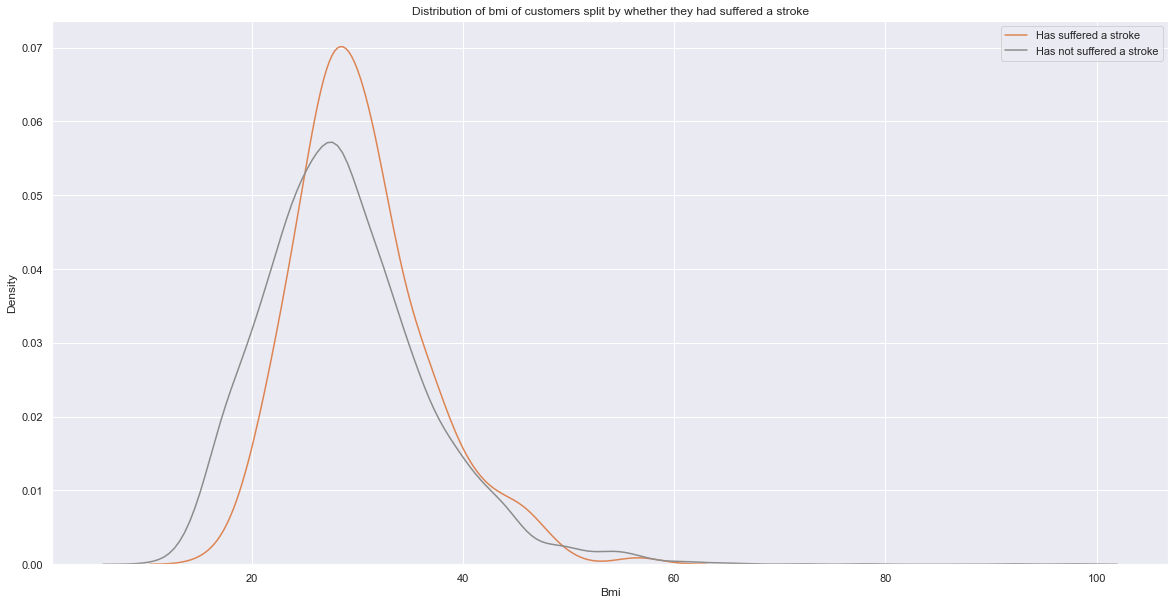

In [42]:
draw_kdeplot(
    data,
    "bmi",
    "stroke",
    [
        "Distribution of bmi of customers split by whether they had suffered a stroke",
        "Bmi",
        "Density",
        "Has suffered a stroke",
        "Has not suffered a stroke",
    ],
)

The distributions for bmi column seem to be quite similar with the peak for stroke patients at slightly higher bmi value than for non stroke patients. 

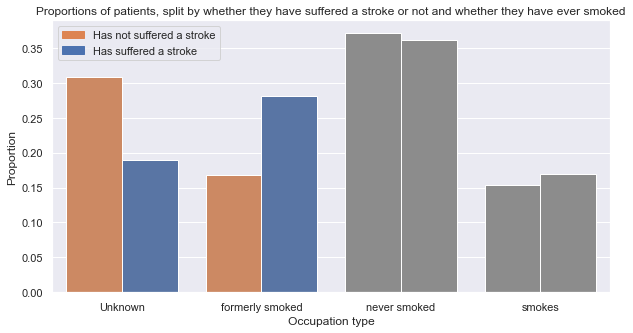

In [43]:
draw_comparison_barplot(
    data,
    "stroke",
    "smoking_status",
    ["Unknown", "formerly smoked"],
    [
        "Proportions of patients, split by whether they have suffered a stroke or not and whether they have ever smoked",
        "Occupation type",
        "Proportion",
        "Has not suffered a stroke",
        "Has suffered a stroke",
    ],
    largefig=False,
    mode="proportion",
)

And finally for the smoking_status feature, we can see that the proportions for "never smoked" and "smokes" values are quite similar, while we can see that the proportion of stroke patients that formerly smoked is quite larger than for non stroke patients. 'Unknown" value has the opposite imbalance of patients. This could be explained by children failing to answer to the question either by thinking it is not targeted at them, or by trying to conceal the fact that they smoke.

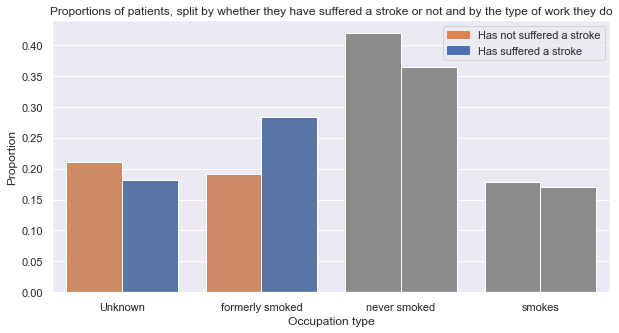

In [44]:
draw_comparison_barplot(
    data[~(data["work_type"] == "children")],
    "stroke",
    "smoking_status",
    ["Unknown", "formerly smoked"],
    [
        "Proportions of patients, split by whether they have suffered a stroke or not and by the type of work they do",
        "Occupation type",
        "Proportion",
        "Has not suffered a stroke",
        "Has suffered a stroke",
    ],
    largefig=False,
    mode="proportion",
)

And we can see that by only looking at patients that don't have work_type set as children, we get rid of most of the imbalance for the "Unknown" value.

## Dealing with missing data

Before we continue on feature engineering and modelling, we should split the dataset into test and train partitions.

In [45]:
train_set, test_set, train_stroke, test_stroke = train_test_split(
    data.loc[:, data.columns[data.columns != "stroke"]],
    data["stroke"],
    test_size=0.2,
    random_state=42,
    stratify=data["stroke"],
)

Let's deal with the missing data next. We'll begin with bmi column

In [46]:
round(train_set["bmi"].isnull().sum() / train_set.shape[0] * 100, 2)

3.99

4% of the total data has bmi value missing.

In [47]:
missing_bmi = train_set.merge(train_stroke, left_index=True, right_index=True).loc[
    :, ["bmi", "stroke"]
]
missing_bmi.loc[missing_bmi["bmi"].isna(), "missing"] = 1
missing_bmi.fillna(0, inplace=True)

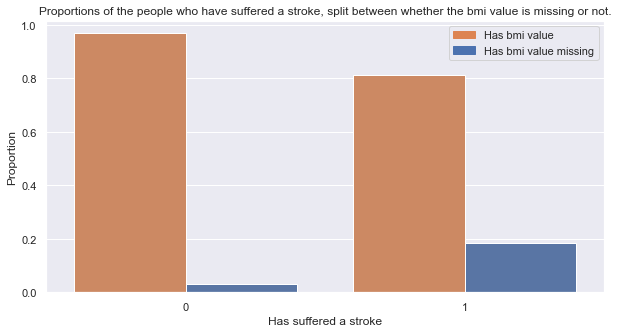

In [48]:
draw_comparison_barplot(
    missing_bmi,
    "missing",
    "stroke",
    [],
    [
        "Proportions of the people who have suffered a stroke, split between whether the bmi value is missing or not.",
        "Has suffered a stroke",
        "Proportion",
        "Has bmi value",
        "Has bmi value missing",
    ],
    largefig=False,
    mode="proportion",
)

And we can see that the proportion of missing values is larger for people who have suffered a stroke.

In [49]:
train_set["bmi"].corr(train_set["age"])

0.33214169883928474

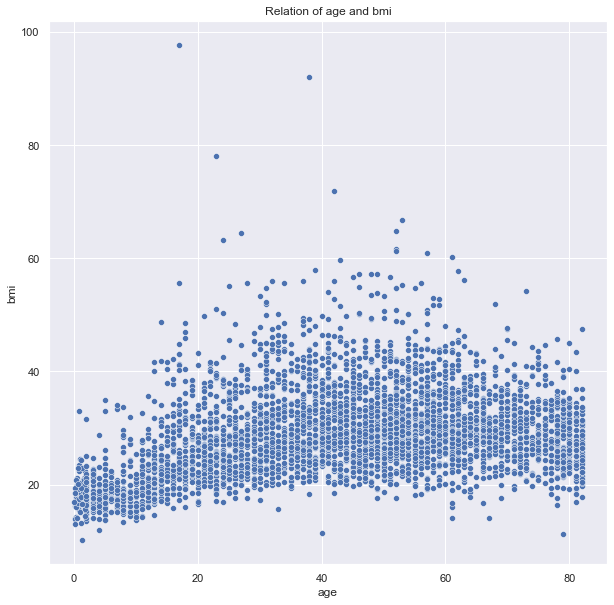

In [50]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=train_set, y="bmi", x="age")
ax.set_title("Relation of age and bmi")
ax.set(xlabel="age", ylabel="bmi")
plt.show()

The correlation between bmi and age seems to be pretty decent. We will be using age column to help fill the missing values.

In [51]:
missing_data = pd.get_dummies(train_set)
missing_data.corrwith(missing_data["bmi"])

age                               0.332142
hypertension                      0.173405
heart_disease                     0.039203
avg_glucose_level                 0.164635
bmi                               1.000000
gender_Female                     0.028979
gender_Male                      -0.028979
ever_married_No                  -0.341478
ever_married_Yes                  0.341478
work_type_Govt_job                0.078945
work_type_Never_worked           -0.028831
work_type_Private                 0.211648
work_type_Self-employed           0.072930
work_type_children               -0.452186
residence_type_Rural             -0.003618
residence_type_Urban              0.003618
smoking_status_Unknown           -0.271392
smoking_status_formerly smoked    0.107473
smoking_status_never smoked       0.104150
smoking_status_smokes             0.094898
dtype: float64

The other strong correlations for bmi seem to be "ever_married_No", "work_type_children" and "smoking_status_Unknown". However all of these features, as we saw in the EDA part, are heavily impacted by age, so we will not be using those.

In [52]:
train_set_eda = train_set.copy()
missing_dict = {"bmi": "nan", "smoking_status": "Unknown"}
fill_na_bmi = skl_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("fill_na_bmi", AgeGroupsMeanBmi()),
    ]
)
train_set_eda = fill_na_bmi.fit_transform(train_set_eda)

train_set_eda.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,missing_data,age_mean_bmi
id,,,,,,,,,,,,
25283,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0.0,31.4
41917,Female,29.0,0,0,No,Private,Urban,84.19,21.2,never smoked,0.0,29.4
36045,Female,35.0,0,0,Yes,Private,Rural,119.40,22.9,never smoked,0.0,31.5
28315,Male,38.0,0,0,Yes,Private,Rural,108.68,32.7,never smoked,0.0,31.5
26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,1.0,22.7


So we split the age in several buckets, took the mean bmi for each and then filled the missing bmi values with those. We also left the mean bmi values in age_mean_bmi column and added a missing_data column to signalize where there is data missing. In the missing_data column we also regarded the "Unknown" values from "smoking_status" feature as missing data. Let's get to those next.

In [53]:
round(
    train_set[train_set["smoking_status"] == "Unknown"].shape[0]
    / train_set.shape[0]
    * 100,
    2,
)

30.24

We can see that nearly a third of all patients have put the "smoking_status" as "Unknown". Since, as we previously saw, a large part of these patients were children, we can maybe put at least the "Unknown" values for children as "never smoked".

In [54]:
train_set_eda[train_set_eda["work_type"] == "children"]["smoking_status"].value_counts()

Unknown            499
never smoked        44
formerly smoked     10
smokes               2
Name: smoking_status, dtype: int64

However, if we take a closer look, while the majority of children that didn't answer "Unknown" did answer "never smoked", a fifth answered that they have smoked. So, without knowing more about the reasons for the "Unknown" value, and seeing that there is a reasonable percentage of children that have smoked, we can't really impute the values in such a blanket way.

In [55]:
train_set_eda.loc[:, train_set_eda.columns[train_set_eda.dtypes == "object"]].head()

,gender,ever_married,work_type,residence_type,smoking_status
id,,,,,
25283,Female,Yes,Private,Urban,never smoked
41917,Female,No,Private,Urban,never smoked
36045,Female,Yes,Private,Rural,never smoked
28315,Male,Yes,Private,Rural,never smoked
26325,Male,No,Govt_job,Urban,Unknown


To check whether there are any meaningful correlations between "smoking_status" and other features to help us impute the missing values, we'll need to convert all the columns containing string values to numerical data. "gender", "ever_married" and "residence_type" are all binary columns, so the transform for those is pretty straightforward. "work_type" colum has more than two values, but they seem to be unrelated to each other, so one hot encoder will for that as well. However, the data in "smoking_status" can be seen as ordered - "never_smoked", "formerly smoked", "smokes" - so we will be using OrdinalEncoder for this column. We will also scale the features.

In [56]:
categorical_features = (
    train_set_eda.columns[train_set_eda.dtypes == "object"]
    .drop("smoking_status")
    .tolist()
)
numeral_features = train_set_eda.columns[~(train_set_eda.dtypes == "object")]

ordinal_pipeline = skl_pipeline(
    [
        (
            "to_ordinal",
            OrdinalEncoder(
                categories=[["never smoked", "formerly smoked", "smokes", "Unknown"]]
            ),
        ),
        ("unknown_to_nan", UnknownToNan(3)),
        ("scaler", MinMaxScaler()),
    ]
)

full_pipeline = ColumnTransformer(
    [
        ("ordinal", ordinal_pipeline, ["smoking_status"]),
        ("categorical", OneHotEncoder(drop="first"), categorical_features),
        ("numeral", MinMaxScaler(), numeral_features),
    ]
)

train_set_eda_num = full_pipeline.fit_transform(train_set_eda)
column_names = np.concatenate(
    [
        full_pipeline.transformers_[0][1]["to_ordinal"].feature_names_in_,
        full_pipeline.transformers_[1][1].get_feature_names_out(categorical_features),
        numeral_features,
    ]
)
train_set_eda_num = pd.DataFrame(
    train_set_eda_num, index=train_set_eda.index, columns=column_names
)
train_set_eda_num.head()

,smoking_status,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,age,hypertension,heart_disease,avg_glucose_level,bmi,missing_data,age_mean_bmi
id,,,,,,,,,,,,,,,
25283,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.584961,0.0,0.0,0.064613,0.261168,0.0,0.968992
41917,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.353027,0.0,0.0,0.133798,0.124857,0.0,0.813953
36045,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.426270,0.0,0.0,0.296416,0.144330,0.0,0.976744
28315,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.462891,0.0,0.0,0.246906,0.256586,0.0,0.976744
26325,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.169922,0.0,0.0,0.125254,0.243986,1.0,0.294574


In [57]:
train_set_eda_num.corrwith(train_set_eda_num["smoking_status"])

smoking_status             1.000000
gender_Male                0.080130
ever_married_Yes           0.081270
work_type_Never_worked    -0.050306
work_type_Private          0.026366
work_type_Self-employed    0.003645
work_type_children        -0.076085
residence_type_Urban       0.027289
age                        0.064217
hypertension               0.000036
heart_disease              0.073019
avg_glucose_level          0.020179
bmi                        0.046382
missing_data               0.102576
age_mean_bmi               0.138238
dtype: float64

There don't seem to be any meaningful correlations between "smoking_status" and other features. Since there doesn't seem to be a quick fix, we will be using K-nearest neighbours imputer.

In [59]:
train_set_eda = train_set.copy()

ordinal_pipeline = skl_pipeline(
    [
        (
            "to_ordinal",
            OrdinalEncoder(
                categories=[["never smoked", "formerly smoked", "smokes", "Unknown"]]
            ),
        ),
        ("unknown_to_nan", UnknownToNan(3)),
    ]
)

categorical_pipeline = ColumnTransformer(
    [
        ("ordinal", ordinal_pipeline, ["smoking_status"]),
        ("categorical", OneHotEncoder(drop="first"), categorical_features),
    ],
    remainder="passthrough",
)

preprocessor = skl_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("fill_na_bmi", AgeGroupsMeanBmi()),
        ("categorical", categorical_pipeline),
        ("scaler", MinMaxScaler()),
        ("knn_imputer", KNNImputer()),
    ]
)

train_set_eda_num = preprocessor.fit_transform(train_set_eda)
numeral_features = train_set_eda.columns[~(train_set_eda.dtypes == "object")]
column_names = np.concatenate(
    [
        preprocessor.steps[2][1].transformers_[0][1]["to_ordinal"].feature_names_in_,
        preprocessor.steps[2][1]
        .transformers_[1][1]
        .get_feature_names_out(categorical_features),
        numeral_features,
        ["missing_data", "age_mean_bmi"],
    ]
)
train_set_eda_num = pd.DataFrame(
    train_set_eda_num, index=train_set_eda.index, columns=column_names
)

train_set_eda_num.head()

,smoking_status,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,age,hypertension,heart_disease,avg_glucose_level,bmi,missing_data,age_mean_bmi
id,,,,,,,,,,,,,,,
25283,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.584961,0.0,0.0,0.064613,0.261168,0.0,0.968992
41917,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.353027,0.0,0.0,0.133798,0.124857,0.0,0.813953
36045,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.426270,0.0,0.0,0.296416,0.144330,0.0,0.976744
28315,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.462891,0.0,0.0,0.246906,0.256586,0.0,0.976744
26325,0.3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.169922,0.0,0.0,0.125254,0.243986,1.0,0.294574


And with clean and scaled data, we can go on to training default models

## Training default models

Since we are trying to predict a binary value, we have a classification problem. First let's just get a baseline models for various classification algorithms.

In [151]:
models = [
    ["svm_rbf", SVC()],
    ["k_neighbors", KNeighborsClassifier()],
    ["logistic_reg", LogisticRegression()],
    ["decision_tree", DecisionTreeClassifier()],
    ["random_forest", RandomForestClassifier()],
    ["boosted_model", GradientBoostingClassifier()],
]

model_scores = pd.DataFrame(
    columns=["f1_score", "recall", "precision", "roc_auc", "model", "fit_time"]
)

for model in models:
    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", MinMaxScaler()),
            ("knn_imputer", KNNImputer()),
            (model[0], model[1]),
        ]
    )
    temp = cross_validate(
        pipe,
        train_set,
        train_stroke,
        cv=5,
        scoring=("f1", "recall", "precision", "roc_auc"),
    )
    model_scores.loc["default_" + model[0]] = [
        temp["test_f1"].mean(),
        temp["test_recall"].mean(),
        temp["test_precision"].mean(),
        temp["test_roc_auc"].mean(),
        model[0],
        temp["fit_time"].mean(),
    ]

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

In [81]:
model_scores

,f1_score,recall,precision,roc_auc,model,fit_time
default_svm_rbf,0.000000,0.000000,0.000000,0.635379,svm_rbf,0.960998
default_svm_poly,0.000000,0.000000,0.000000,0.627279,svm_poly,1.211001
default_k_neighbors,0.026790,0.015003,0.125000,0.612138,k_neighbors,0.763166
default_logistic_reg,0.000000,0.000000,0.000000,0.841892,logistic_reg,0.697667
default_decision_tree,0.180085,0.185680,0.177833,0.570592,decision_tree,0.541496
default_random_forest,0.027027,0.015003,0.138889,0.809551,random_forest,1.139833
default_boosted_model,0.044833,0.024807,0.250000,0.833206,boosted_model,1.242166


In [180]:
train_stroke.value_counts()

0    3888
1     199
Name: stroke, dtype: int64

Our dataset is quite imbalanced, which results in best models being those that just predict one class. We'll use an oversampler to mitigate this.

In [61]:
models = [
    ["svm_rbf", SVC()],
    ["k_neighbors", KNeighborsClassifier()],
    ["logistic_reg", LogisticRegression()],
    ["decision_tree", DecisionTreeClassifier()],
    ["random_forest", RandomForestClassifier()],
    ["boosted_model", GradientBoostingClassifier()],
]
model_scores = pd.DataFrame(
    columns=[
        "f1_score",
        "recall",
        "precision",
        "roc_auc",
        "average_precision",
        "model",
        "fit_time",
        "tuned",
    ]
)

for model in models:
    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", MinMaxScaler()),
            ("knn_imputer", KNNImputer()),
            ("smote", SMOTE(random_state=11)),
            (model[0], model[1]),
        ]
    )

    temp = cross_validate(
        pipe,
        train_set,
        train_stroke,
        cv=5,
        scoring=(
            "f1",
            "recall",
            "precision",
            "accuracy",
            "roc_auc",
            "average_precision",
        ),
    )
    model_scores.loc["default_" + model[0]] = [
        temp["test_f1"].mean(),
        temp["test_recall"].mean(),
        temp["test_precision"].mean(),
        temp["test_roc_auc"].mean(),
        temp["test_average_precision"].mean(),
        model[0],
        temp["fit_time"].mean(),
        "default",
    ]

In [62]:
model_scores

,f1_score,recall,precision,roc_auc,average_precision,model,fit_time,tuned
default_svm_rbf,0.205181,0.572436,0.125395,0.779484,0.159607,svm_rbf,1.753598,default
default_k_neighbors,0.170659,0.341538,0.114115,0.637407,0.084820,k_neighbors,0.296200,default
default_logistic_reg,0.230467,0.823974,0.134237,0.839661,0.177351,logistic_reg,0.317802,default
default_decision_tree,0.132125,0.155769,0.115920,0.547792,0.061031,decision_tree,0.307798,default
default_random_forest,0.132993,0.110513,0.171203,0.816822,0.158178,random_forest,0.973600,default
default_boosted_model,0.223241,0.291026,0.181478,0.813882,0.155580,boosted_model,1.350399,default


The numbers we can see now are a lot more reasonable. Interesting thing to notice is that decision tree actually had a better f1 score without SMOTE. Let's plot these values.

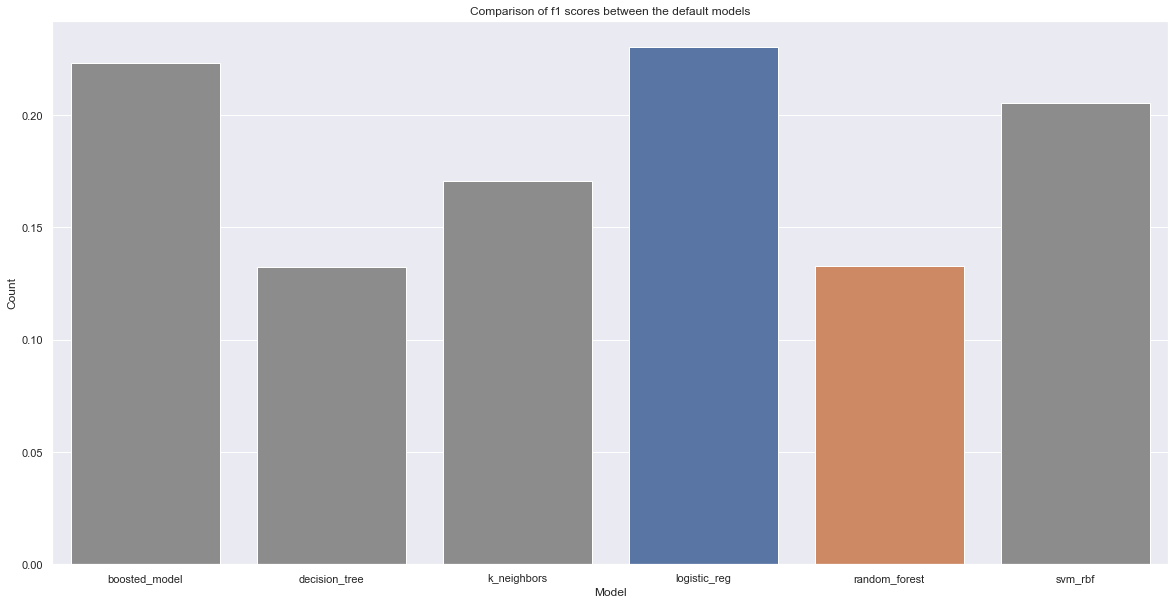

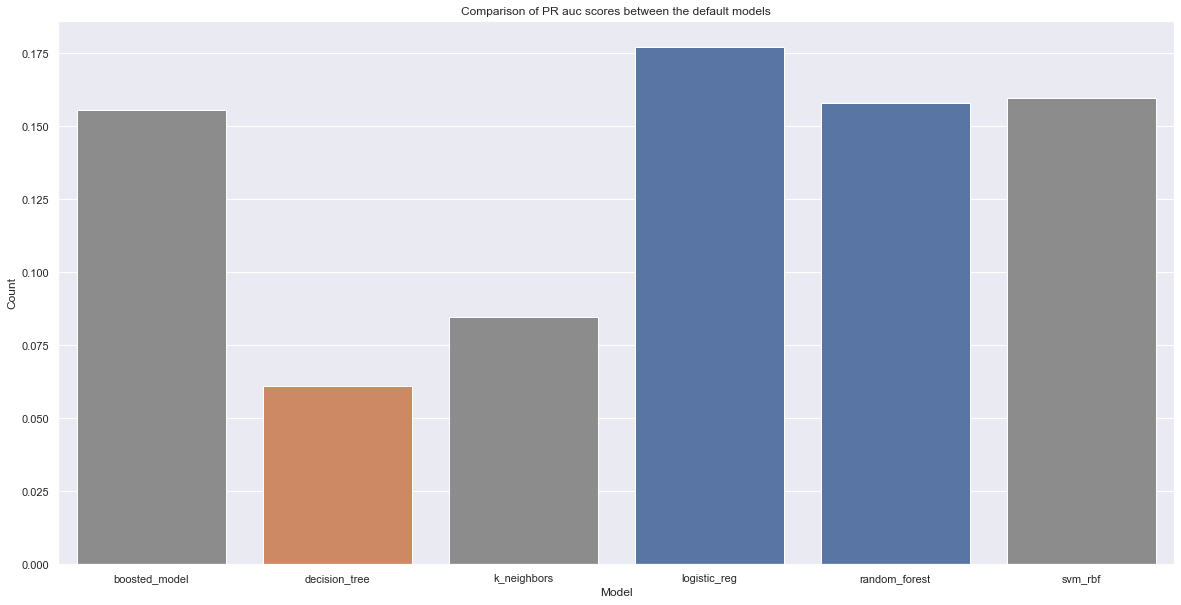

In [63]:
draw_color_barplot(
    model_scores,
    "model",
    "f1_score",
    "model",
    [
        "Comparison of f1 scores between the default models",
        "Model",
        "Count",
    ],
    ["logistic_reg"],
    ["random_forest"],
)

draw_color_barplot(
    model_scores,
    "model",
    "average_precision",
    "model",
    [
        "Comparison of PR auc scores between the default models",
        "Model",
        "Count",
    ],
    ["logistic_reg", "random_forest"],
    ["decision_tree"],
)

For the start, we are mostly interested on pr auc metric. As we can see logistic regression seems to be a promising model for both f1 score and pr auc, but pr auc is quite high for also random_forest, svm_rbf and boosted_model. 
We will tune the hyperparameters for all of the models, however first lets try engineering some features. We will use the autofeat classifier model, to see whether it fares better as any of the baseline models we already looked at.

In [77]:
train_set_val, test_set_val, train_stroke_val, test_stroke_val = train_test_split(
    train_set, train_stroke, test_size=0.2, random_state=42, stratify=train_stroke
)

pipe = imb_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("fill_na_bmi", AgeGroupsMeanBmi()),
        ("categorical", categorical_pipeline),
        ("knn_imputer", KNNImputer()),
        ("smote", SMOTE(random_state=11)),
        ("autofeat", AutoFeatClassifier(verbose=1)),
    ]
)
train_set_val_2 = pipe.fit_transform(train_set_val, train_stroke_val)

[AutoFeat] The 2 step feature engineering process could generate up to 5565 features.
[AutoFeat] With 6220 data points this new feature matrix would use about 0.14 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 60 transformed features from 15 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 2675 feature combinations from 2775 original feature tuples - done.
[feateng] Generated altogether 2820 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 1724 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 146 features after 5 feature selection runs
[featsel] 82 features after correlation filtering
[featsel] 73 features after noise filterin

[AutoFeat] Computing 72 new features.
[AutoFeat]    72/   72 new features ...done.


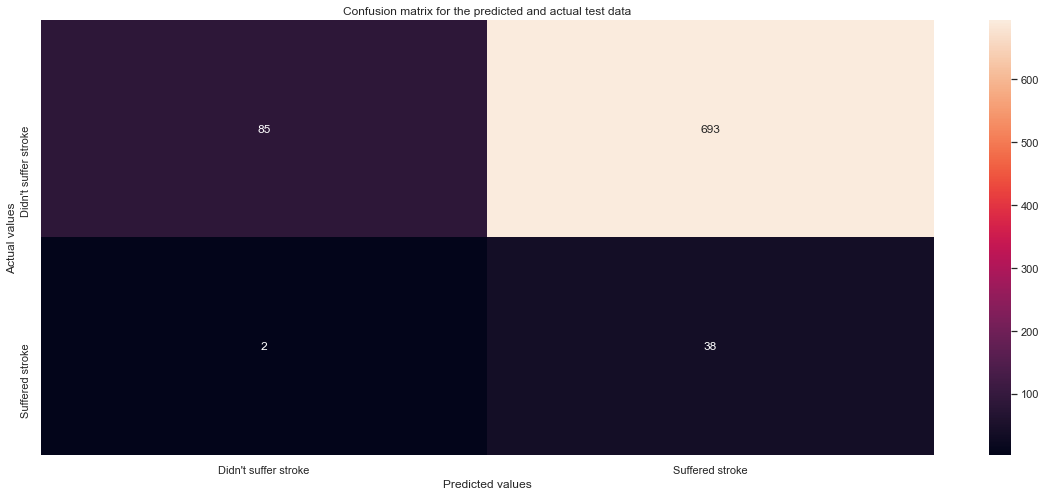

In [78]:
matrix = confusion_matrix(test_stroke_val, pipe.predict(test_set_val))
label_list = ["Didn't suffer stroke", "Suffered stroke"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

And we can see that the model seems to be quite massively overtrained for the positive class. We will not be exploring this approach further.

## Hypertuning

For hypertuning we will be using optuna with 300 trials and we will be tuning to maximize pr auc metric. Besides hyperparameter tuning, we will also try several scalers and oversamplers, to see whether any of them fits better than MinMax and SMOTE we used previously. We will also immediately export the optuna study files, as well as the best models, so we don't have to retrain them in case we need to restart kernel. 

In [82]:
def objective_svc(trial):

    oversamplers = trial.suggest_categorical("oversampler", ["ROS", "SMOTE", "ADASYN"])
    if oversamplers == "ROS":
        oversampler = RandomOverSampler(sampling_strategy="minority")
    elif oversamplers == "SMOTE":
        oversampler = SMOTE(sampling_strategy="minority")
    else:
        oversampler = ADASYN(sampling_strategy="minority")

    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    c = trial.suggest_float("c", 1e-10, 1e3, log=True)
    kernel = trial.suggest_categorical("kernel", ["rbf", "poly"])

    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", scaler),
            ("knn_imputer", KNNImputer()),
            ("oversampler", oversampler),
            ("SVC", SVC(C=c, kernel=kernel, gamma="auto")),
        ]
    )

    print(pipe)
    score = cross_val_score(
        pipe,
        train_set,
        train_stroke,
        n_jobs=-1,
        cv=5,
        scoring="average_precision",
        verbose=30,
    )
    pr_auc = score.mean()
    return pr_auc

In [87]:
def objective_knn(trial):

    oversamplers = trial.suggest_categorical("oversampler", ["ROS", "SMOTE", "ADASYN"])
    if oversamplers == "ROS":
        oversampler = RandomOverSampler(sampling_strategy="minority")
    elif oversamplers == "SMOTE":
        oversampler = SMOTE(sampling_strategy="minority")
    else:
        oversampler = ADASYN(sampling_strategy="minority")

    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    criterion = trial.suggest_int("n_neighbors", 1, 21, log=True)
    metric = trial.suggest_categorical(
        "metric", ["euclidean", "manhattan", "minkowski"]
    )
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])

    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", scaler),
            ("knn_imputer", KNNImputer()),
            ("oversampler", oversampler),
            (
                "KNN",
                KNeighborsClassifier(
                    n_neighbors=n_neighbors, metric=metric, weights=weights
                ),
            ),
        ]
    )

    print(pipe)
    score = cross_val_score(
        pipe,
        train_set,
        train_stroke,
        n_jobs=-1,
        cv=5,
        scoring="average_precision",
        verbose=30,
    )
    pr_auc = score.mean()
    return pr_auc

In [78]:
def objective_log(trial):

    oversamplers = trial.suggest_categorical("oversampler", ["ROS", "SMOTE", "ADASYN"])
    if oversamplers == "ROS":
        oversampler = RandomOverSampler(sampling_strategy="minority")
    elif oversamplers == "SMOTE":
        oversampler = SMOTE(sampling_strategy="minority")
    else:
        oversampler = ADASYN(sampling_strategy="minority")

    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    c = trial.suggest_float("c", 1e-10, 1e3, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2", "none"])

    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", scaler),
            ("knn_imputer", KNNImputer()),
            ("oversampler", oversampler),
            ("log_reg", LogisticRegression(C=c, penalty=penalty)),
        ]
    )

    models[trial.number] = pipe
    score = cross_val_score(
        pipe,
        train_set,
        train_stroke,
        n_jobs=-1,
        cv=5,
        scoring="average_precision",
        verbose=30,
    )
    pr_auc = score.mean()
    return pr_auc

In [74]:
def objective_tree(trial):

    oversamplers = trial.suggest_categorical("oversampler", ["ROS", "SMOTE", "ADASYN"])
    if oversamplers == "ROS":
        oversampler = RandomOverSampler(sampling_strategy="minority")
    elif oversamplers == "SMOTE":
        oversampler = SMOTE(sampling_strategy="minority")
    else:
        oversampler = ADASYN(sampling_strategy="minority")

    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    max_depth = trial.suggest_int("max_depth", 2, 100, log=True)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    min_impurity_decrease = trial.suggest_float(
        "min_impurity_decrease", 1e-10, 1e-2, log=True
    )

    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", scaler),
            ("knn_imputer", KNNImputer()),
            ("oversampler", oversampler),
            (
                "decision_tree",
                DecisionTreeClassifier(
                    max_depth=max_depth,
                    criterion=criterion,
                    min_impurity_decrease=min_impurity_decrease,
                ),
            ),
        ]
    )

    models[trial.number] = pipe
    score = cross_val_score(
        pipe,
        train_set,
        train_stroke,
        n_jobs=-1,
        cv=5,
        scoring="average_precision",
        verbose=30,
    )
    pr_auc = score.mean()
    return pr_auc

In [75]:
def objective_forest(trial):

    oversamplers = trial.suggest_categorical("oversampler", ["ROS", "SMOTE", "ADASYN"])
    if oversamplers == "ROS":
        oversampler = RandomOverSampler(sampling_strategy="minority")
    elif oversamplers == "SMOTE":
        oversampler = SMOTE(sampling_strategy="minority")
    else:
        oversampler = ADASYN(sampling_strategy="minority")

    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 100, log=True)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    min_impurity_decrease = trial.suggest_float(
        "min_impurity_decrease", 1e-10, 1e-2, log=True
    )

    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", scaler),
            ("knn_imputer", KNNImputer()),
            ("oversampler", oversampler),
            (
                "decision_tree",
                RandomForestClassifier(
                    n_estimators,
                    max_depth=max_depth,
                    criterion=criterion,
                    min_impurity_decrease=min_impurity_decrease,
                ),
            ),
        ]
    )

    models[trial.number] = pipe
    score = cross_val_score(
        pipe,
        train_set,
        train_stroke,
        n_jobs=-1,
        cv=5,
        scoring="average_precision",
        verbose=30,
    )
    pr_auc = score.mean()
    return pr_auc

In [81]:
def objective_booster(trial):

    oversamplers = trial.suggest_categorical("oversampler", ["ROS", "SMOTE", "ADASYN"])
    if oversamplers == "ROS":
        oversampler = RandomOverSampler(sampling_strategy="minority")
    elif oversamplers == "SMOTE":
        oversampler = SMOTE(sampling_strategy="minority")
    else:
        oversampler = ADASYN(sampling_strategy="minority")

    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    learning_rate = trial.suggest_float("learning_rate", 1e-10, 1e-2, log=True)
    n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 100, log=True)
    min_impurity_decrease = trial.suggest_float(
        "min_impurity_decrease", 1e-10, 1e-2, log=True
    )

    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", scaler),
            ("knn_imputer", KNNImputer()),
            ("oversampler", oversampler),
            (
                "decision_tree",
                GradientBoostingClassifier(
                    learning_rate=learning_rate,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_impurity_decrease=min_impurity_decrease,
                ),
            ),
        ]
    )

    models[trial.number] = pipe
    score = cross_val_score(
        pipe,
        train_set,
        train_stroke,
        n_jobs=-1,
        cv=5,
        scoring="average_precision",
        verbose=30,
    )
    pr_auc = score.mean()
    return pr_auc

In [ ]:
models = {}
optuna_tree = optuna.create_study(direction="maximize")
optuna_tree.optimize(objective_tree, n_trials=300)
joblib.dump(optuna_tree, "models//optuna_tree.pkl")
best_tree_model = models[optuna_tree.best_trial.number]
joblib.dump(best_tree_model, "models//best_optuna_tree.pkl")

In [ ]:
models = {}
optuna_forest = optuna.create_study(direction="maximize")
optuna_forest.optimize(objective_forest, n_trials=300)
joblib.dump(optuna_forest, "models//optuna_forest.pkl")
best_forest_model = models[optuna_forest.best_trial.number]
joblib.dump(best_forest_model, "models//best_optuna_forest.pkl")

In [ ]:
models = {}
optuna_booster = optuna.create_study(direction="maximize")
optuna_booster.optimize(objective_booster, n_trials=300)
joblib.dump(optuna_booster, "models//optuna_booster.pkl")
best_booster_model = models[optuna_booster.best_trial.number]
joblib.dump(best_booster_model, "models//best_optuna_booster.pkl")

In [ ]:
models = {}
optuna_forest_2 = optuna.create_study(direction="maximize")
optuna_forest_2.optimize(objective_forest, n_trials=300)
joblib.dump(optuna_forest_2, "models//optuna_forest_2.pkl")
best_forest_model_2 = models[optuna_forest_2.best_trial.number]
joblib.dump(best_forest_model_2, "models//best_optuna_forest_2.pkl")

In [ ]:
models = {}
optuna_booster_2 = optuna.create_study(direction="maximize")
optuna_booster_2.optimize(objective_booster, n_trials=300)
joblib.dump(optuna_booster_2, "models//optuna_booster_2.pkl")
best_booster_model_2 = models[optuna_booster_2.best_trial.number]
joblib.dump(best_booster_model_2, "models//best_optuna_booster_2.pkl")

In [ ]:
optuna_svc = optuna.create_study(direction="maximize")
optuna_svc.optimize(objective_svc, n_trials=500)
joblib.dump(optuna_svc, "models//optuna_svc.pkl")

In [ ]:
optuna_knn = optuna.create_study(direction="maximize")
optuna_knn.optimize(objective_knn, n_trials=300)
joblib.dump(optuna_knn, "models//optuna_knn.pkl")

In [ ]:
optuna_log = optuna.create_study(direction="maximize")
optuna_log.optimize(objective_log, n_trials=300)
joblib.dump(optuna_log, "models//optuna_log.pkl")

In [184]:
optuna_forest_2.best_trial.value

0.22594513856397205

So far we have gotten the best value from a random forest model. We will define another objective for random forest centered around the values that got the best result and adding some other hyperparameters to see whether we can squeeze an even better result out.

In [96]:
def objective_forest_2(trial):

    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    n_estimators = trial.suggest_int("n_estimators", 700, 1200)
    max_depth = trial.suggest_int("max_depth", 10, 30, log=True)
    min_impurity_decrease = trial.suggest_float(
        "min_impurity_decrease", 1e-5, 1e-2, log=True
    )
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50, log=True)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 300, log=True)

    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", scaler),
            ("knn_imputer", KNNImputer()),
            ("oversampler", RandomOverSampler(sampling_strategy="minority")),
            (
                "decision_tree",
                RandomForestClassifier(
                    n_estimators,
                    max_depth=max_depth,
                    criterion="entropy",
                    min_impurity_decrease=min_impurity_decrease,
                    min_samples_leaf=min_samples_leaf,
                    max_leaf_nodes=max_leaf_nodes,
                ),
            ),
        ]
    )

    models[trial.number] = pipe
    score = cross_val_score(
        pipe,
        train_set,
        train_stroke,
        n_jobs=-1,
        cv=5,
        scoring="average_precision",
        verbose=30,
    )
    pr_auc = score.mean()
    return pr_auc

In [ ]:
models = {}
optuna_forest_3 = optuna.create_study(direction="maximize")
optuna_forest_3.optimize(objective_forest_2, n_trials=300)
joblib.dump(optuna_forest_3, "models//optuna_forest_3.pkl")
best_forest_model_3 = models[optuna_forest_3.best_trial.number]
joblib.dump(best_forest_model_3, "models//best_optuna_forest_3.pkl")

We did not manage to get a better random forest value.

We will now load the models, in case kernel has been restarted. For some of the models we do not have the best model saved, so we will write them down manually.

In [181]:
optuna_svc = joblib.load("models//optuna_svc.pkl")
optuna_log = joblib.load("models//optuna_log.pkl")
optuna_knn = joblib.load("models//optuna_knn.pkl")
best_tree_model = joblib.load("models//best_optuna_tree.pkl")
best_forest_model_2 = joblib.load("models//best_optuna_forest_2.pkl")
best_booster_model = joblib.load("models//best_optuna_booster.pkl")

In [66]:
optuna_svc.best_params

{'oversampler': 'ROS',
 'scaler': 'MinMax',
 'c': 0.42191115527805084,
 'kernel': 'rbf'}

In [67]:
svc_pipe = imb_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("fill_na_bmi", AgeGroupsMeanBmi()),
        ("categorical", categorical_pipeline),
        ("scaler", MinMaxScaler()),
        ("knn_imputer", KNNImputer()),
        ("oversampler", RandomOverSampler(sampling_strategy="minority")),
        (
            "SVC",
            SVC(C=0.42191115527805084, kernel="rbf", gamma="auto", probability=True),
        ),
    ]
)

In [68]:
optuna_log.best_params

{'oversampler': 'ROS',
 'scaler': 'Robust',
 'c': 0.41254044210554863,
 'penalty': 'l2'}

In [60]:
log_pipe = imb_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("fill_na_bmi", AgeGroupsMeanBmi()),
        ("categorical", categorical_pipeline),
        ("scaler", RobustScaler()),
        ("knn_imputer", KNNImputer()),
        ("oversampler", RandomOverSampler(sampling_strategy="minority")),
        ("log_reg", LogisticRegression(C=0.41254044210554863, penalty="l2")),
    ]
)

In [70]:
optuna_knn.best_params

{'oversampler': 'SMOTE',
 'scaler': 'MinMax',
 'n_neighbors': 21,
 'metric': 'manhattan',
 'weights': 'distance'}

In [71]:
knn_pipe = imb_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("fill_na_bmi", AgeGroupsMeanBmi()),
        ("categorical", categorical_pipeline),
        ("scaler", MinMaxScaler()),
        ("knn_imputer", KNNImputer()),
        ("oversampler", SMOTE(sampling_strategy="minority")),
        (
            "KNN",
            KNeighborsClassifier(
                n_neighbors=21, metric="manhattan", weights="distance"
            ),
        ),
    ]
)

Before we go on let's make an ensemble voting model using the best models we previously got.

In [166]:
ensemble = VotingClassifier(
    estimators=[
        ("forest_1", best_forest_model),
        ("forest_2", best_forest_model_2),
        ("forest_3", best_forest_model_3),
        ("boosted", best_booster_model),
        ("svc", svc_pipe),
    ],
    voting="hard",
)

In [175]:
ensemble.fit(train_set_val, train_stroke_val)
average_precision_score(test_stroke_val, ensemble.predict(test_set_val))

0.13530209704720705

The ensemble model performed a lot worse than other models. We will not try to improve it.

In [72]:
models = [
    ["svm_rbf", svc_pipe],
    ["k_neighbors", knn_pipe],
    ["logistic_reg", log_pipe],
    ["decision_tree", best_tree_model],
    ["random_forest", best_forest_model_2],
    ["boosted_model", best_booster_model],
]

for model in models:

    temp = cross_validate(
        model[1],
        train_set,
        train_stroke,
        cv=5,
        scoring=(
            "f1",
            "recall",
            "precision",
            "accuracy",
            "roc_auc",
            "average_precision",
        ),
    )
    model_scores.loc["tuned_" + model[0]] = [
        temp["test_f1"].mean(),
        temp["test_recall"].mean(),
        temp["test_precision"].mean(),
        temp["test_roc_auc"].mean(),
        temp["test_average_precision"].mean(),
        model[0],
        temp["fit_time"].mean(),
        "tuned",
    ]

In [73]:
model_scores

,f1_score,recall,precision,roc_auc,average_precision,model,fit_time,tuned
default_svm_rbf,0.205181,0.572436,0.125395,0.779484,0.159607,svm_rbf,1.753598,default
default_k_neighbors,0.170659,0.341538,0.114115,0.637407,0.084820,k_neighbors,0.296200,default
default_logistic_reg,0.230467,0.823974,0.134237,0.839661,0.177351,logistic_reg,0.317802,default
default_decision_tree,0.132125,0.155769,0.115920,0.547792,0.061031,decision_tree,0.307798,default
default_random_forest,0.132993,0.110513,0.171203,0.816822,0.158178,random_forest,0.973600,default
default_boosted_model,0.223241,0.291026,0.181478,0.813882,0.155580,boosted_model,1.350399,default
tuned_svm_rbf,0.231243,0.823846,0.134722,0.840675,0.194472,svm_rbf,12.497788,tuned
tuned_k_neighbors,0.188909,0.441667,0.120621,0.732200,0.119397,k_neighbors,0.317798,tuned
tuned_logistic_reg,0.229489,0.834103,0.133310,0.842853,0.190515,logistic_reg,0.329599,tuned
tuned_decision_tree,0.218950,0.311026,0.170199,0.770262,0.154227,decision_tree,0.295397,tuned


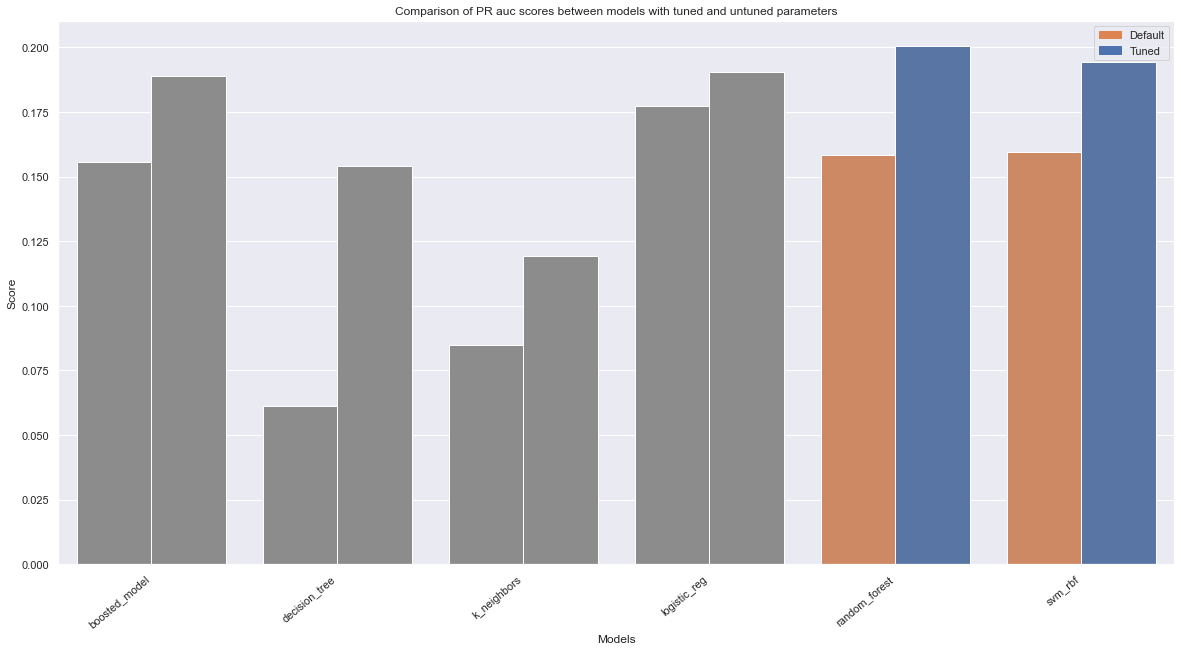

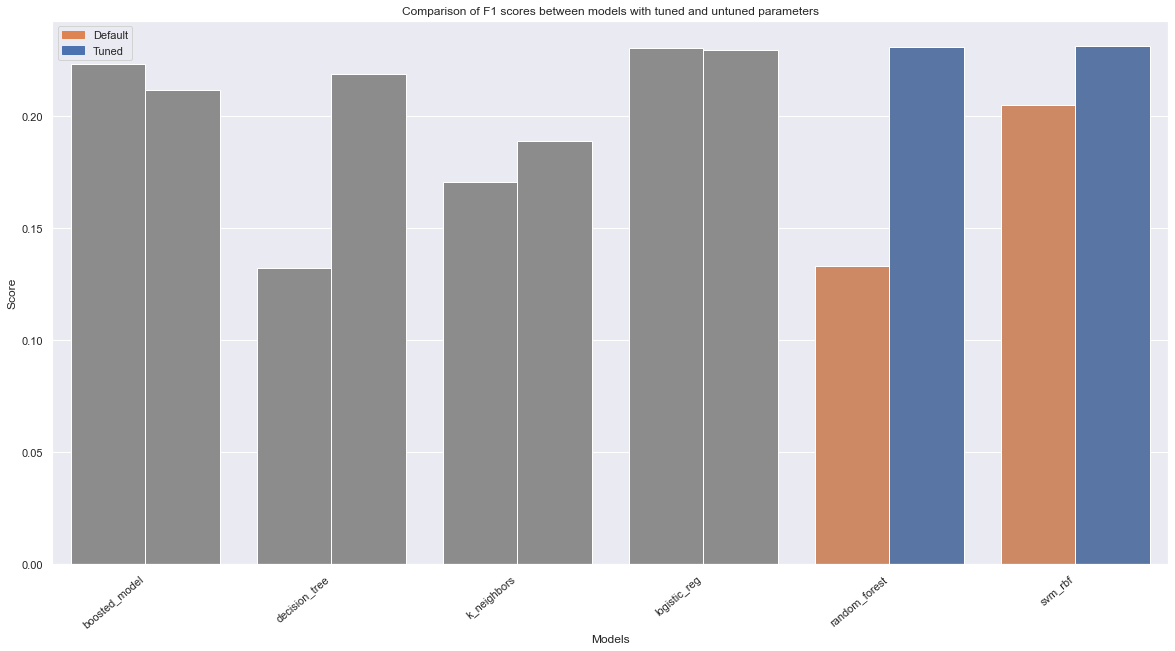

In [75]:
model_scores.index.name = "name"
model_scores["count"] = model_scores["average_precision"]
draw_comparison_barplot(
    model_scores,
    "tuned",
    "model",
    ["random_forest", "svm_rbf"],
    [
        "Comparison of PR auc scores between models with tuned and untuned parameters",
        "Models",
        "Score",
        "Default",
        "Tuned",
    ],
    rotate_x=True,
    mode="diff",
)

model_scores["count"] = model_scores["f1_score"]
draw_comparison_barplot(
    model_scores,
    "tuned",
    "model",
    ["random_forest", "svm_rbf"],
    [
        "Comparison of F1 scores between models with tuned and untuned parameters",
        "Models",
        "Score",
        "Default",
        "Tuned",
    ],
    rotate_x=True,
    mode="diff",
)

We can see in the comparisons between default and tuned models than even though untuned random_forest and svm had worse pr auc score for the default metric than logistic regression, for the tuned models, the pr auc metric is actually better than it is for the tuned logistic regression.

Let's plot the pr curves for the tuned logistic regression, random forest and svm.

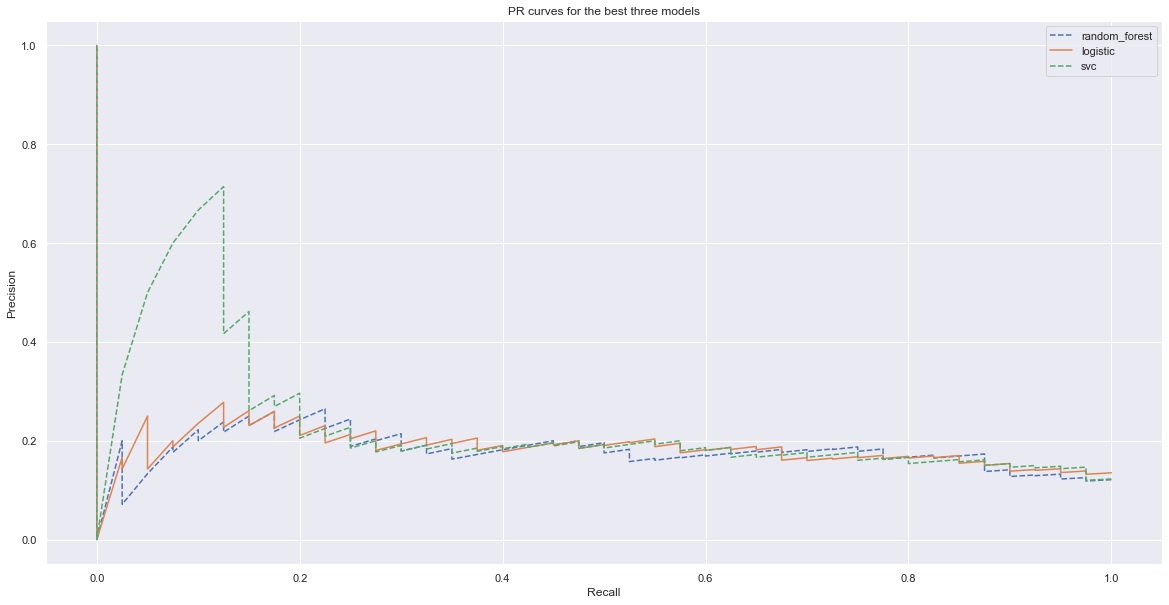

In [79]:
log_pipe.fit(train_set_val, train_stroke_val)
best_forest_model_2.fit(train_set_val, train_stroke_val)
svc_pipe.fit(train_set_val, train_stroke_val)

forest_yhat = best_forest_model_2.predict_proba(test_set_val)
forest_yhat = forest_yhat[:, 1]
log_yhat = log_pipe.predict_proba(test_set_val)
log_yhat = log_yhat[:, 1]
svc_yhat = svc_pipe.predict_proba(test_set_val)
svc_yhat = svc_yhat[:, 1]

forest_precision, forest_recall, forest_thresholds = precision_recall_curve(
    test_stroke_val, forest_yhat
)
log_precision, log_recall, log_thresholds = precision_recall_curve(
    test_stroke_val, log_yhat
)
svc_precision, svc_recall, svc_thresholds = precision_recall_curve(
    test_stroke_val, svc_yhat
)

plt.figure(figsize=(20, 10))
plt.plot(forest_recall, forest_precision, linestyle="--", label="random_forest")
plt.plot(log_recall, log_precision, linestyle="-", label="logistic")
plt.plot(svc_recall, svc_precision, linestyle="--", label="svc")
plt.title("PR curves for the best three models")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In this problem we are mostly interested in recall - if you're a doctor, the mistake of saying to someone who is in danger of suffering a stroke that they are safe is much larger than the mistake of paying extra attention to someone who is safe due to a misdiagnosis. Since that is the case, we are interested in which model has the best precision values where the recall value is above 0.8. We can see that none of the models seem to be obviously better than the others, so we will take the simplest and fastest one - Logistic regression.

Before we go on, though, let's try to tune the hyperparameters for another random forest model - this time scoring them by f1 score, to see whether we cannot get a better result.

In [260]:
def objective_forest_f1(trial):

    oversamplers = trial.suggest_categorical("oversampler", ["ROS", "SMOTE", "ADASYN"])
    if oversamplers == "ROS":
        oversampler = RandomOverSampler(sampling_strategy="minority")
    elif oversamplers == "SMOTE":
        oversampler = SMOTE(sampling_strategy="minority")
    else:
        oversampler = ADASYN(sampling_strategy="minority")

    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 100, log=True)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    min_impurity_decrease = trial.suggest_float(
        "min_impurity_decrease", 1e-10, 1e-2, log=True
    )

    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", scaler),
            ("knn_imputer", KNNImputer()),
            ("oversampler", oversampler),
            (
                "decision_tree",
                RandomForestClassifier(
                    n_estimators,
                    max_depth=max_depth,
                    criterion=criterion,
                    min_impurity_decrease=min_impurity_decrease,
                ),
            ),
        ]
    )

    models[trial.number] = pipe
    score = cross_val_score(
        pipe, train_set, train_stroke, n_jobs=-1, cv=5, scoring="f1", verbose=30
    )
    f1 = score.mean()
    return f1

In [ ]:
models = {}
optuna_forest_f1 = optuna.create_study(direction="maximize")
optuna_forest_f1.optimize(objective_forest_f1, n_trials=300)
joblib.dump(optuna_forest_f1, "models//optuna_forest_f1.pkl")
optuna_forest_f1_model = models[optuna_forest_f1.best_trial.number]
joblib.dump(optuna_forest_f1_model, "models//optuna_forest_f1_model.pkl")

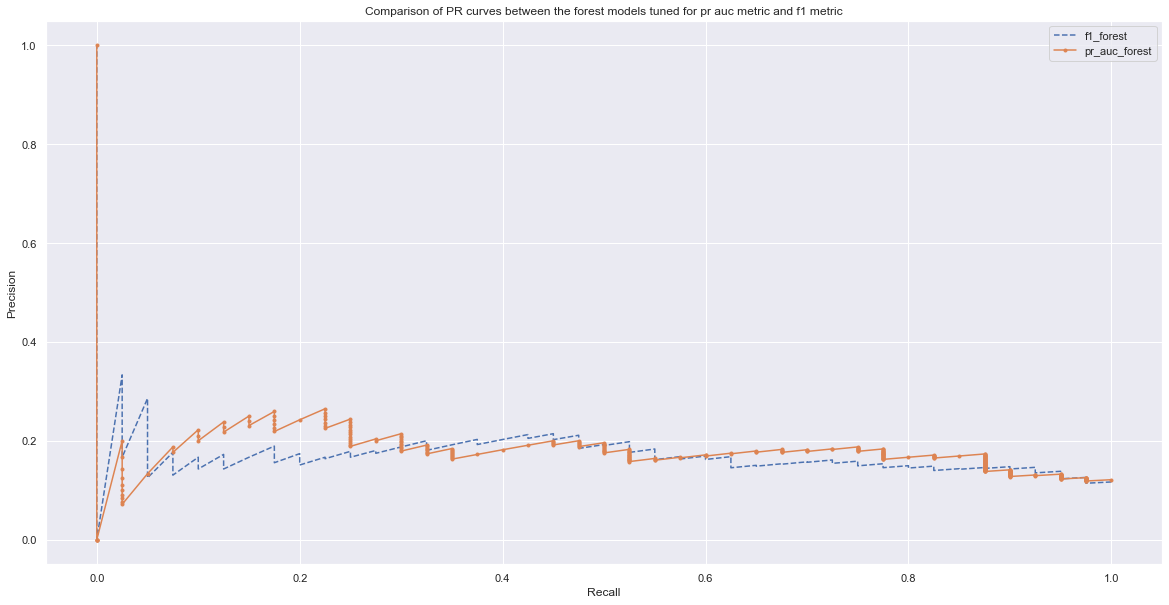

In [83]:
optuna_forest_f1_model = joblib.load("models//optuna_forest_f1_model.pkl")
optuna_forest_f1_model.fit(train_set_val, train_stroke_val)

f1_yhat = optuna_forest_f1_model.predict_proba(test_set_val)
f1_yhat = f1_yhat[:, 1]
yhat = best_forest_model_2.predict_proba(test_set_val)
yhat = yhat[:, 1]

f1_precision, f1_recall, f1_thresholds = precision_recall_curve(
    test_stroke_val, f1_yhat
)
precision, recall, thresholds = precision_recall_curve(test_stroke_val, yhat)

plt.figure(figsize=(20, 10))
plt.plot(f1_recall, f1_precision, linestyle="--", label="f1_forest")
plt.plot(recall, precision, marker=".", label="pr_auc_forest")
plt.title(
    "Comparison of PR curves between the forest models tuned for pr auc metric and f1 metric"
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

We can see that the model scored by f1 is noticeably worse than the model scored by pr auc.

## Final model testing and explanation

Let's plot the results for the best model on a confusion matrix.

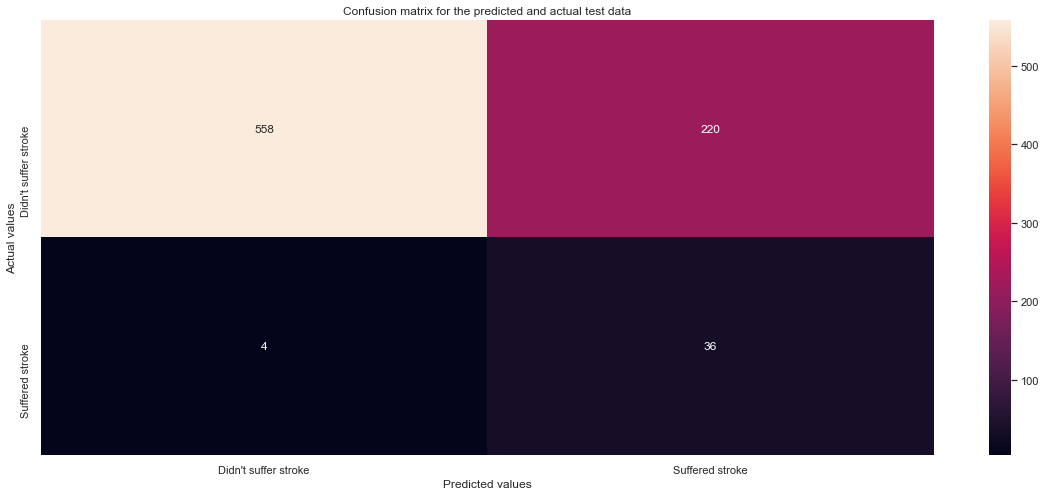

In [85]:
log_pipe.fit(train_set_val, train_stroke_val)
matrix = confusion_matrix(test_stroke_val, log_pipe.predict(test_set_val))
label_list = ["Didn't suffer stroke", "Suffered stroke"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

We can see that even though there are a lot more false positives than true positives, model has correctly predicted most of the positive cases. Also the balance between false positives and true negatives is pretty good.

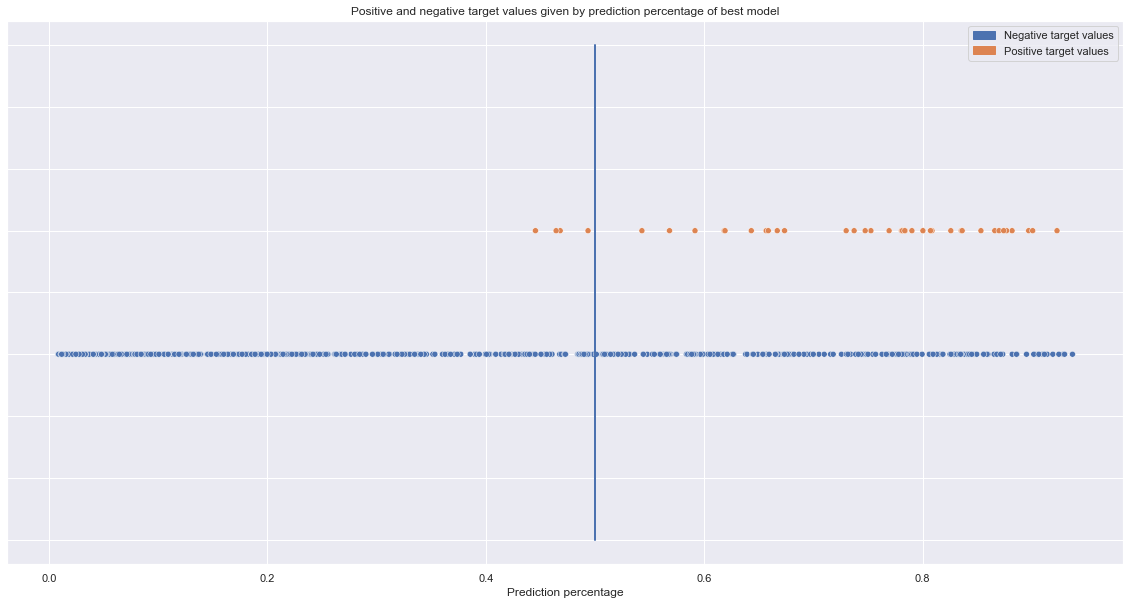

In [88]:
df_colors = pd.DataFrame()
df_colors["predictions"] = log_pipe.predict_proba(test_set_val)[:, 1]
df_colors["y_numbers"] = np.array(test_stroke_val)
df_colors["loc"] = np.zeros(len(test_stroke_val))
df_colors.loc[df_colors["y_numbers"] == 0, "loc"] -= 0.25
df_colors.loc[df_colors["y_numbers"] == 1, "loc"] += 0.25

plt.figure(figsize=(20, 10))
ax = sns.scatterplot(data=df_colors, x="predictions", y="loc", hue="y_numbers")

blue_patch = mpatches.Patch(color=colors["blue"], label="Negative target values")
orange_patch = mpatches.Patch(color=colors["orange"], label="Positive target values")
plt.legend(handles=[blue_patch, orange_patch])
ax.set_xlabel("Prediction percentage")
ax.set_ylabel("")
ax.axes.yaxis.set_ticklabels([])
ax.set_title(
    "Positive and negative target values given by prediction percentage of best model"
)
plt.plot([0.5, 0.5], [-1, 1], linewidth=2)
plt.show()

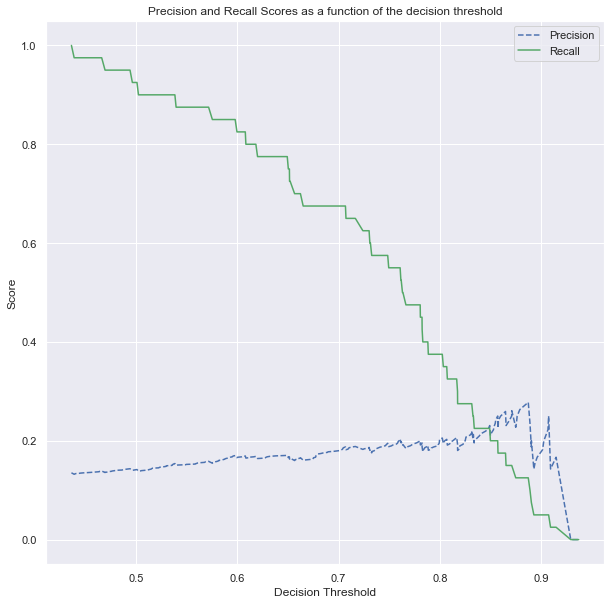

In [84]:
yhat = log_pipe.predict_proba(test_set_val)
yhat = yhat[:, 1]
precision, recall, thresholds = precision_recall_curve(test_stroke_val, yhat)

plt.figure(figsize=(10, 10))
plt.title("Precision and Recall Scores as a function of the decision threshold")
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc="best")
plt.show()

We can see that if we move the threshold just a bit from the default 0.5, we'll get most of the false negatives over the threshold line. 

In [85]:
log_pipe_thresh = imb_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("fill_na_bmi", AgeGroupsMeanBmi()),
        ("categorical", categorical_pipeline),
        ("scaler", log_pipe[-4]),
        ("knn_imputer", KNNImputer()),
        ("oversampler", log_pipe[-2]),
        ("model", Thresholder(log_pipe[-1], 0.45)),
    ]
)

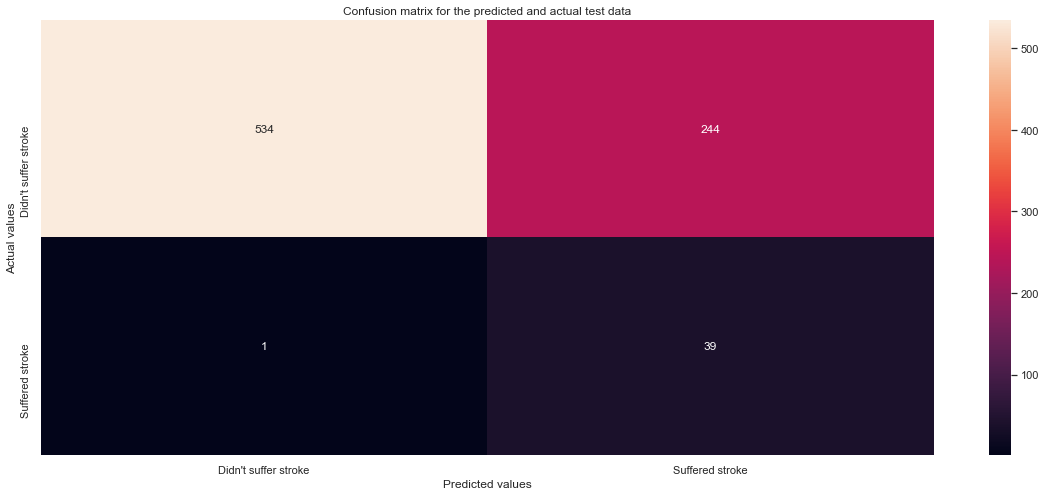

In [86]:
log_pipe_thresh.fit(train_set_val, train_stroke_val)
matrix = confusion_matrix(test_stroke_val, log_pipe_thresh.predict(test_set_val))
label_list = ["Didn't suffer stroke", "Suffered stroke"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

And we can see that by moving the threshold line to correctly predict all but one of the positive cases, we have increased the false positive count only by a little.

Let's see how well we do on the test data.

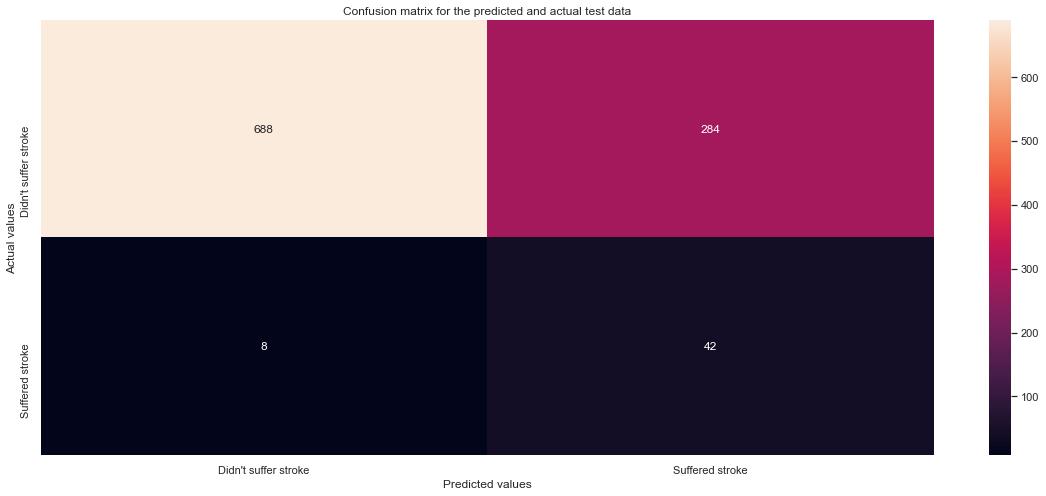

In [94]:
log_pipe.fit(train_set, train_stroke)
matrix = confusion_matrix(test_stroke, log_pipe.predict(test_set))
label_list = ["Didn't suffer stroke", "Suffered stroke"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

In [95]:
print(f"Recall: {recall_score(test_stroke, log_pipe.predict(test_set))}")
print(f"Precision: {precision_score(test_stroke, log_pipe.predict(test_set))}")

Recall: 0.84
Precision: 0.12883435582822086


We can see that the model performed a lot worse on the test data. Recall is still pretty high, but not as high as we would like for a serious medical instrument. Let's take a closer look at those false negatives.

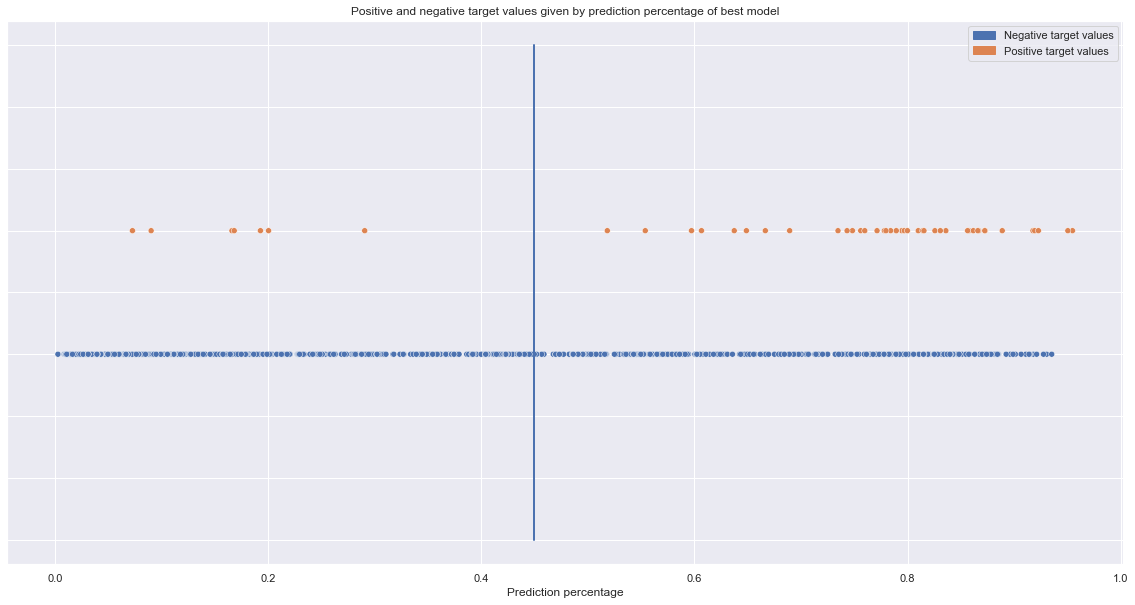

In [89]:
df_colors = pd.DataFrame()
df_colors["predictions"] = log_pipe.predict_proba(test_set)[:, 1]
df_colors["y_numbers"] = np.array(test_stroke)
df_colors["loc"] = np.zeros(len(test_stroke))
df_colors.loc[df_colors["y_numbers"] == 0, "loc"] -= 0.25
df_colors.loc[df_colors["y_numbers"] == 1, "loc"] += 0.25

plt.figure(figsize=(20, 10))
ax = sns.scatterplot(data=df_colors, x="predictions", y="loc", hue="y_numbers")

blue_patch = mpatches.Patch(color=colors["blue"], label="Negative target values")
orange_patch = mpatches.Patch(color=colors["orange"], label="Positive target values")
plt.legend(handles=[blue_patch, orange_patch])
ax.set_xlabel("Prediction percentage")
ax.set_ylabel("")
ax.axes.yaxis.set_ticklabels([])
ax.set_title(
    "Positive and negative target values given by prediction percentage of best model"
)
plt.plot([0.45, 0.45], [-1, 1], linewidth=2)
plt.show()

The incorrectly predicted values are nowhere close to the threshold line. 

Let's take a closer look at the model with shap!

In [61]:
shap.initjs()

In [62]:
transformer = skl_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("fill_na_bmi", AgeGroupsMeanBmi()),
        ("categorical", categorical_pipeline),
        ("scaler", log_pipe[-4]),
        ("knn_imputer", KNNImputer()),
    ]
)

train_shap = transformer.fit_transform(train_set)
test_shap = transformer.transform(test_set)
column_names = np.concatenate(
    [
        transformer.steps[2][1].transformers_[0][1]["to_ordinal"].feature_names_in_,
        transformer.steps[2][1]
        .transformers_[1][1]
        .get_feature_names_out(categorical_features),
        numeral_features,
        ["missing_data", "age_mean_bmi"],
    ]
)
train_shap = pd.DataFrame(train_shap, index=train_set.index, columns=column_names)
test_shap = pd.DataFrame(test_shap, index=test_set.index, columns=column_names)

sampler = log_pipe[-2]
log_reg = log_pipe[-1]
train_shap, train_shap_stroke = sampler.fit_resample(train_shap, train_stroke)

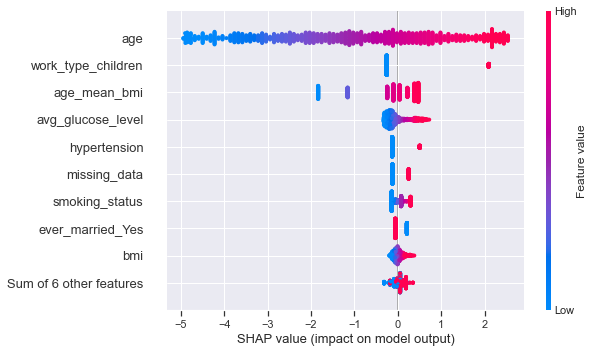

In [64]:
log_reg.fit(train_shap, train_shap_stroke)
explainer = shap.Explainer(log_reg, train_shap, feature_names=train_shap.columns)
shap_values = explainer(test_shap)

shap.plots.beeswarm(shap_values)

Unsuprisingly, the biggest impact on the predictions is given by the age of the patient. Age_mean_bmi is also an age related feature, as is work_type_children. Peculiarly the work_type_children having a value of 1, actually increases the possibility of stroke in the models interpretation. But glucose level, hypertension and smoking status also seem to have an impact.

In [65]:
shap.plots.force(shap_values[0])

In [66]:
shap.plots.force(shap_values[150])

In [67]:
shap.plots.force(shap_values[436])

If we look at the individual values, we can also see that age is undoubtedly the leading predictor.

Let's look at the 8 false negatives again.

In [68]:
test_set[(test_stroke == 1) & ~(test_stroke == log_reg.predict(test_shap))]

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
31563,Female,38.0,0,0,Yes,Private,Rural,101.45,NaN,formerly smoked
54385,Male,45.0,0,0,Yes,Private,Rural,64.14,29.4,never smoked
39912,Female,32.0,0,0,Yes,Private,Rural,76.13,29.9,smokes
14499,Male,47.0,0,0,Yes,Private,Urban,86.94,41.1,formerly smoked
33943,Female,39.0,0,0,Yes,Private,Urban,83.24,26.3,never smoked
49669,Female,14.0,0,0,No,children,Rural,57.93,30.9,Unknown
33879,Male,42.0,0,0,Yes,Private,Rural,83.41,25.4,Unknown
31154,Female,39.0,0,0,Yes,Self-employed,Urban,97.76,29.6,smokes


In [69]:
weird_set = test_shap[(test_stroke == 1) & ~(test_stroke == log_reg.predict(test_shap))]
shap_values = explainer(weird_set)

In [70]:
shap.plots.force(shap_values[0])

In [71]:
shap.plots.force(shap_values[1])

In [72]:
shap.plots.force(shap_values[5])

We can see that all of them are quite young. If we look at the values in other columns - negative hypertension, low glucose, low bmi, residence_type Rural - all of them are more similar to the values for negative cases than to the values for positive cases. 
Since that is the case, I don't belive that with the data we have we would be able to catch them even with a better trained model - to be able to catch these extreme cases, we would need either more features or more cases. 

In [92]:
joblib.dump(log_pipe, "models\\trained_models\\best_stroke_model_trained.pkl")

['models\\trained_models\\best_stroke_model_trained.pkl']

## Bmi column prediction

Let's train the model for bmi feature next. Since bmi contains continuous numerical data, we will be using regression to predict it.

In [98]:
bmi_data = data.copy()
bmi_data.drop("stroke", axis=1, inplace=True)
bmi_data.dropna(axis=0, inplace=True)

train_set_bmi, test_set_bmi, train_bmi, test_bmi = train_test_split(
    bmi_data.loc[:, bmi_data.columns[bmi_data.columns != "bmi"]],
    bmi_data["bmi"],
    test_size=0.2,
    random_state=42,
)

train_set_bmi.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,smoking_status
id,,,,,,,,,
68302,Female,40.0,0,0,Yes,Private,Urban,65.77,never smoked
62716,Female,59.0,0,0,Yes,Self-employed,Urban,81.64,Unknown
38796,Female,54.0,0,0,Yes,Private,Urban,99.83,formerly smoked
4148,Male,81.0,0,0,Yes,Self-employed,Urban,71.18,formerly smoked
61672,Female,11.0,0,0,No,children,Urban,69.68,Unknown


In [102]:
missing_dict = {"smoking_status": "Unknown"}

bmi_pipe = skl_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("categorical", categorical_pipeline),
        ("scaler", MinMaxScaler()),
        ("knn_imputer", KNNImputer()),
        ("linear_reg", LinearRegression()),
    ]
)

We will start by training a basic linear regression model as a baseline.

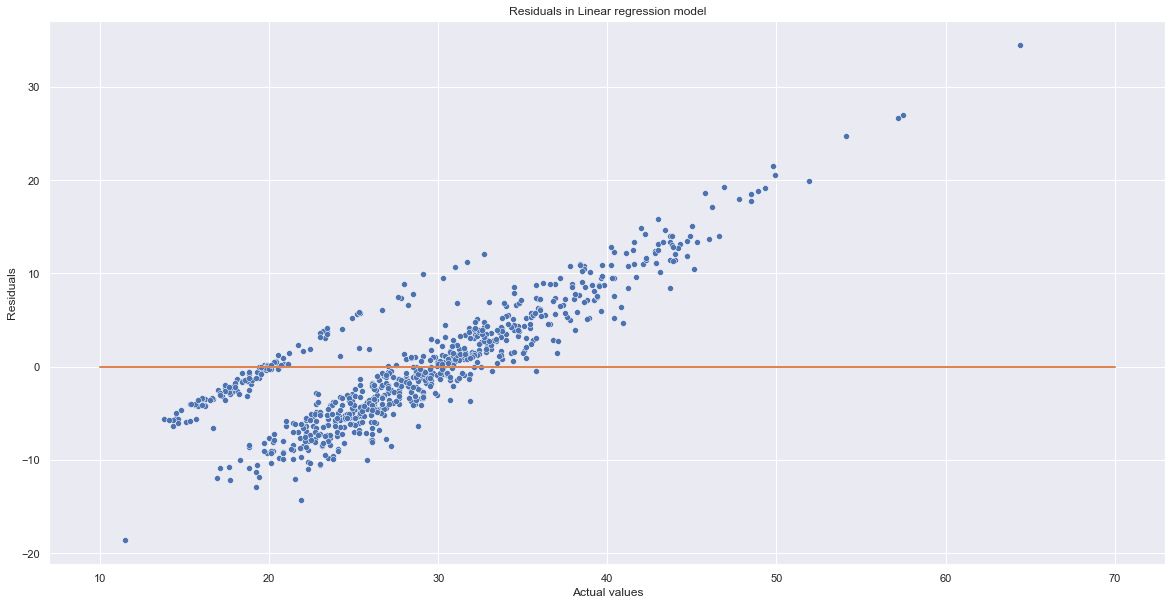

In [104]:
train_set_bmi_val, test_set_bmi_val, train_bmi_val, test_bmi_val = train_test_split(
    train_set_bmi, train_bmi, test_size=0.2, random_state=42
)

bmi_pipe.fit(train_set_bmi_val, train_bmi_val)

plt.figure(figsize=(20, 10))
ax = sns.scatterplot(
    x=test_bmi_val, y=test_bmi_val - bmi_pipe.predict(test_set_bmi_val)
)
plt.plot([10, 70], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Actual values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals in Linear regression model")
plt.show()

While most of the residuals are within 10 values from the prediction, there are some extreme values. Interesting thing to notice are the two distinct groups. It might be due to a strong influence on the prediction by a binary feature.

In [105]:
bmi_transform = skl_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("categorical", categorical_pipeline),
        ("scaler", MinMaxScaler()),
        ("knn_imputer", KNNImputer()),
    ]
)

bmi_trans_df = bmi_transform.fit_transform(train_set_bmi)

categorical_features = (
    train_set_bmi.columns[train_set_bmi.dtypes == "object"]
    .drop("smoking_status")
    .tolist()
)
numeral_features = train_set_bmi.columns[~(train_set_bmi.dtypes == "object")]
column_names = np.concatenate(
    [
        bmi_transform.steps[1][1].transformers_[0][1]["to_ordinal"].feature_names_in_,
        bmi_transform.steps[1][1]
        .transformers_[1][1]
        .get_feature_names_out(categorical_features),
        numeral_features,
        ["missing_data"],
    ]
)
bmi_trans_df = pd.DataFrame(
    bmi_trans_df, index=train_set_bmi.index, columns=column_names
)

In [106]:
print(f"Intercept: {bmi_pipe[-1].intercept_:.3f}")
print("Coefficients:")
for name, coef in zip(column_names, bmi_pipe[-1].coef_):
    print(f" {name}: {coef:.4}")

Intercept: 28.258
Coefficients:
 smoking_status: 0.802
 gender_Male: 0.3756
 ever_married_Yes: 2.556
 work_type_Never_worked: -4.302
 work_type_Private: -0.2056
 work_type_Self-employed: -0.3235
 work_type_children: -8.436
 residence_type_Urban: -0.2038
 age: -2.2
 hypertension: 2.66
 heart_disease: -1.04
 avg_glucose_level: 4.633
 missing_data: -0.6078


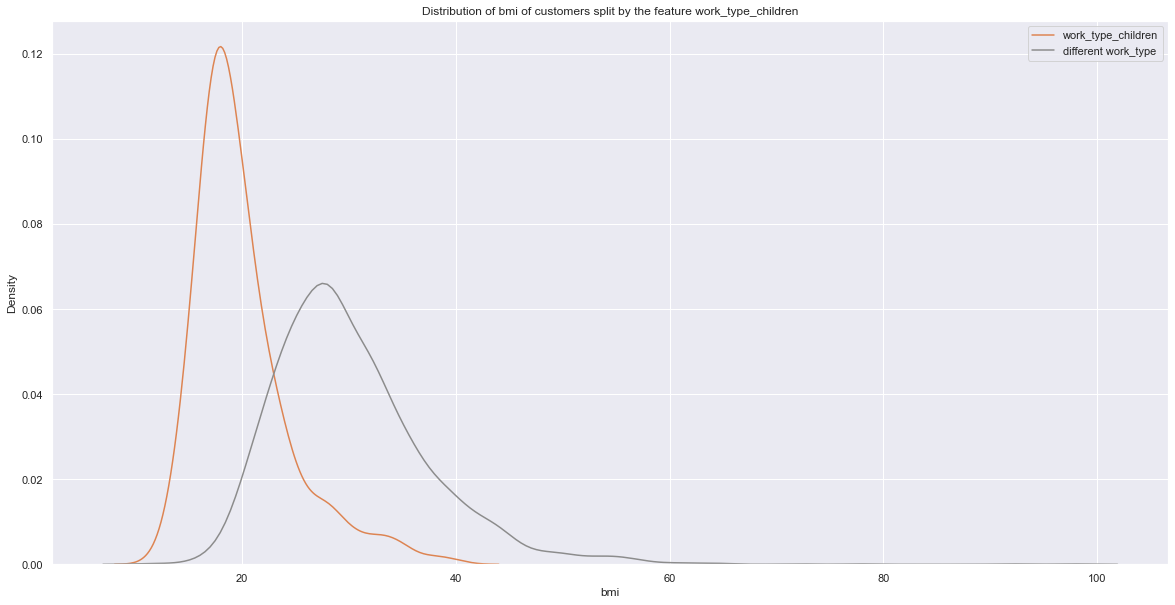

In [109]:
draw_kdeplot(
    bmi_trans_df.merge(train_bmi, left_index=True, right_on="id"),
    "bmi",
    "work_type_children",
    [
        "Distribution of bmi of customers split by the feature work_type_children",
        "bmi",
        "Density",
        "work_type_children",
        "different work_type",
    ],
)

We can see that the largest coefficient for the prediction came from the binary work_type_children feature. We can also see the two distinct distributions for the bmi split by work_type_children and other work_type values. 

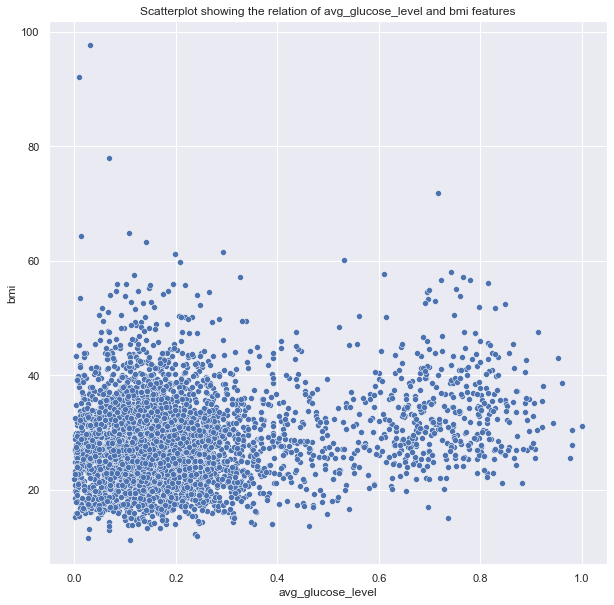

In [111]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x=bmi_trans_df["avg_glucose_level"], y=train_bmi)
plt.title("Scatterplot showing the relation of avg_glucose_level and bmi features")
plt.show()

Average glucose lavel column also had a large coefficient. We can see some correlation in the graph. 

Let's train some other linear models, to see which fits best.

In [89]:
models = [
    ["linear", LinearRegression()],
    ["ridge", Ridge()],
    ["lasso", Lasso()],
    ["sgd", SGDRegressor()],
]
model_scores = pd.DataFrame(
    columns=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error", "fit_time"]
)

for model in models:
    bmi_pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("categorical", categorical_pipeline),
            ("scaler", MinMaxScaler()),
            ("knn_imputer", KNNImputer()),
            (model[0], model[1]),
        ]
    )
    temp = cross_validate(
        bmi_pipe,
        train_set_bmi,
        train_bmi,
        cv=5,
        scoring=("r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"),
    )
    model_scores.loc[model[0]] = [
        temp["test_r2"].mean(),
        temp["test_neg_mean_absolute_error"].mean(),
        temp["test_neg_root_mean_squared_error"].mean(),
        temp["fit_time"].mean(),
    ]

In [90]:
bmi_pipe = imb_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("categorical", categorical_pipeline),
        ("scaler", MinMaxScaler()),
        ("knn_imputer", KNNImputer()),
        ("poly_feat", PolynomialFeatures(degree=2)),
        ("linear", LinearRegression()),
    ]
)
temp = cross_validate(
    bmi_pipe,
    train_set_bmi,
    train_bmi,
    cv=5,
    scoring=("r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"),
)
model_scores.loc["poly"] = [
    temp["test_r2"].mean(),
    temp["test_neg_mean_absolute_error"].mean(),
    temp["test_neg_root_mean_squared_error"].mean(),
    temp["fit_time"].mean(),
]

In [92]:
model_scores

,r2,neg_mean_absolute_error,neg_root_mean_squared_error,fit_time
linear,0.236566,-5.054228,-6.821550,0.260511
ridge,0.236656,-5.053897,-6.821195,0.241201
lasso,0.066743,-5.713095,-7.540983,0.275201
sgd,0.235065,-5.051756,-6.828777,0.384997
poly,0.254209,-5.003170,-6.739062,0.342000


Seems like polynomial model had the best r2 value. Let's see whether changing the scaler improves the score.

In [93]:
scalers = [
    ("MinMax", MinMaxScaler()),
    ("Standard", StandardScaler()),
    ("Robust", RobustScaler()),
]
poly_scalers = pd.DataFrame(
    columns=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error", "fit_time"]
)

for scaler in scalers:
    bmi_pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("categorical", categorical_pipeline),
            (scaler[0], scaler[1]),
            ("knn_imputer", KNNImputer()),
            ("poly_feat", PolynomialFeatures(degree=2)),
            ("linear", LinearRegression()),
        ]
    )

    temp = cross_validate(
        bmi_pipe,
        train_set_bmi,
        train_bmi,
        cv=5,
        scoring=("r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"),
    )
    poly_scalers.loc[scaler[0]] = [
        temp["test_r2"].mean(),
        temp["test_neg_mean_absolute_error"].mean(),
        temp["test_neg_root_mean_squared_error"].mean(),
        temp["fit_time"].mean(),
    ]

In [94]:
poly_scalers

,r2,neg_mean_absolute_error,neg_root_mean_squared_error,fit_time
MinMax,0.254209,-5.003170,-6.739062,0.243996
Standard,0.258700,-4.978707,-6.720757,0.272597
Robust,0.258554,-4.990383,-6.720289,0.246600


And we get a slightly better result with the Standard scaler.

Let's tune the hyperparameters for SGDRegressor, to see whether we can get a better r2 value.

In [189]:
def objective_reg_no_bmi(trial, X: pd.DataFrame, y: pd.Series):

    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    eta0 = trial.suggest_float("eta", 1e-5, 0.1)
    epsilon = trial.suggest_float("epsilon", 1e-3, 0.2)
    alpha = trial.suggest_float("alpha", 1e-6, 1e-3)
    loss = trial.suggest_categorical(
        "loss", ["squared_error", "huber", "epsilon_insensitive"]
    )
    penalty = trial.suggest_categorical("penalty", ["l2", "l1"])
    learning_rate = trial.suggest_categorical(
        "learning_rate", ["optimal", "invscaling", "adaptive"]
    )

    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("categorical", categorical_pipeline),
            ("scaler", scaler),
            ("knn_imputer", KNNImputer()),
            (
                "sgd",
                SGDRegressor(
                    eta0=eta0,
                    epsilon=epsilon,
                    loss=loss,
                    penalty=penalty,
                    learning_rate=learning_rate,
                    alpha=alpha,
                    max_iter=2000,
                ),
            ),
        ]
    )

    models[trial.number] = pipe
    score = cross_val_score(pipe, X, y, n_jobs=-1, cv=5, scoring="r2")
    r2 = score.mean()
    return r2

In [ ]:
models = {}
reg_no_bmi_wrapper = lambda trial: objective_reg_no_bmi(trial, train_set_bmi, train_bmi)
optuna_bmi = optuna.create_study(direction="maximize")
optuna_bmi.optimize(reg_no_bmi_wrapper, n_trials=300)

joblib.dump(optuna_bmi, "models//optuna_bmi.pkl")
best_optuna_bmi = models[optuna_bmi.best_trial.number]
joblib.dump(best_optuna_bmi, "models//best_optuna_bmi.pkl")

In [116]:
best_optuna_bmi = joblib.load("models//best_optuna_bmi.pkl")
optuna_bmi = joblib.load("models//optuna_bmi.pkl")
optuna_bmi.best_trial.value

0.237088871752191

We get a slightly worse result than with the polynomial model. Let's try the model on the test set!

In [490]:
bmi_pipe = imb_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("categorical", categorical_pipeline),
        ("Standard", StandardScaler()),
        ("knn_imputer", KNNImputer()),
        ("poly_feat", PolynomialFeatures(degree=2)),
        ("linear", LinearRegression()),
    ]
)

In [499]:
bmi_pipe.fit(train_set_bmi, train_bmi)
r2_score(test_bmi, bmi_pipe.predict(test_set_bmi))

-9.601698748159433e+18

Something in the test set seems to have broken the polynomial model. Let's check how the best sgdregressor model fares.

In [103]:
best_optuna_bmi.fit(train_set_bmi, train_bmi)
r2_score(test_bmi, best_optuna_bmi.predict(test_set_bmi))

0.23109018424633787

And this model seems to work ok. 23% of variance explained is not too impressive, but a lot better than just taking the mean.

In [114]:
joblib.dump(best_optuna_bmi, "models//trained_models//best_optuna_bmi_trained.pkl")

['models//trained_models//best_optuna_bmi_trained.pkl']

## Average glucose level feature prediction

Let's predict the average glucose level column next!

In [185]:
glucose_data = data.copy()
glucose_data.drop("stroke", axis=1, inplace=True)

train_set_glucose, test_set_glucose, train_glucose, test_glucose = train_test_split(
    glucose_data.loc[
        :, glucose_data.columns[glucose_data.columns != "avg_glucose_level"]
    ],
    glucose_data["avg_glucose_level"],
    test_size=0.2,
    random_state=42,
)

train_set_glucose.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,bmi,smoking_status
id,,,,,,,,,
4970,Male,79.0,0,0,Yes,Self-employed,Rural,28.5,formerly smoked
56137,Female,62.0,0,0,Yes,Private,Urban,36.3,Unknown
54590,Female,21.0,0,0,No,Private,Rural,33.7,never smoked
36548,Male,31.0,0,0,Yes,Govt_job,Urban,30.4,formerly smoked
61171,Female,31.0,0,0,No,Private,Rural,19.9,never smoked


Again the target column contains continuous numeric data, so we will be using regression algorithms.

In [129]:
models = [
    ["linear", LinearRegression()],
    ["ridge", Ridge()],
    ["lasso", Lasso()],
    ["sgd", SGDRegressor()],
]
missing_dict = {"bmi": "nan", "smoking_status": "Unknown"}
model_scores = pd.DataFrame(
    columns=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error", "fit_time"]
)

for model in models:
    glucose_pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", MinMaxScaler()),
            ("knn_imputer", KNNImputer()),
            (model[0], model[1]),
        ]
    )
    temp = cross_validate(
        glucose_pipe,
        train_set_glucose,
        train_glucose,
        cv=5,
        scoring=("r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"),
    )
    model_scores.loc[model[0]] = [
        temp["test_r2"].mean(),
        temp["test_neg_mean_absolute_error"].mean(),
        temp["test_neg_root_mean_squared_error"].mean(),
        temp["fit_time"].mean(),
    ]

In [120]:
glucose_pipe = imb_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("fill_na_bmi", AgeGroupsMeanBmi()),
        ("categorical", categorical_pipeline),
        ("scaler", MinMaxScaler()),
        ("knn_imputer", KNNImputer()),
        ("poly_feat", PolynomialFeatures(degree=2)),
        ("linear", LinearRegression()),
    ]
)
temp = cross_validate(
    glucose_pipe,
    train_set_glucose,
    train_glucose,
    cv=5,
    scoring=("r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"),
)
model_scores.loc["poly"] = [
    temp["test_r2"].mean(),
    temp["test_neg_mean_absolute_error"].mean(),
    temp["test_neg_root_mean_squared_error"].mean(),
    temp["fit_time"].mean(),
]

In [121]:
model_scores

,r2,neg_mean_absolute_error,neg_root_mean_squared_error,fit_time
linear,9.842818e-02,-3.232594e+01,-4.309271e+01,0.293604
ridge,9.850032e-02,-3.231389e+01,-4.309107e+01,0.295199
lasso,6.693294e-02,-3.254794e+01,-4.383917e+01,0.341004
sgd,9.388837e-02,-3.239325e+01,-4.320210e+01,0.413406
poly,-7.892398e+19,-7.838057e+09,-2.039511e+11,0.401800


All the algorithms seem to be doing quite terrible - the best one has only 9.85 of variance explained.

In [122]:
scalers = [
    ("MinMax", MinMaxScaler()),
    ("Standard", StandardScaler()),
    ("Robust", RobustScaler()),
]


lin_scalers = pd.DataFrame(
    columns=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error", "fit_time"]
)

for scaler in scalers:
    glucose_pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            (scaler[0], scaler[1]),
            ("knn_imputer", KNNImputer()),
            ("linear", LinearRegression()),
        ]
    )

    temp = cross_validate(
        glucose_pipe,
        train_set_glucose,
        train_glucose,
        cv=5,
        scoring=("r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"),
    )
    lin_scalers.loc[scaler[0]] = [
        temp["test_r2"].mean(),
        temp["test_neg_mean_absolute_error"].mean(),
        temp["test_neg_root_mean_squared_error"].mean(),
        temp["fit_time"].mean(),
    ]

In [123]:
lin_scalers

,r2,neg_mean_absolute_error,neg_root_mean_squared_error,fit_time
MinMax,0.098428,-32.325936,-43.092714,0.440401
Standard,0.098429,-32.326186,-43.092610,0.420601
Robust,0.098378,-32.327011,-43.093865,0.448800


Changing the scaler doesn't seem to impact the score too much.

In [186]:
(
    train_set_glucose_val,
    test_set_glucose_val,
    train_glucose_val,
    test_glucose_val,
) = train_test_split(train_set_glucose, train_glucose, test_size=0.2, random_state=42)

glucose_pipe = imb_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("fill_na_bmi", AgeGroupsMeanBmi()),
        ("categorical", categorical_pipeline),
        ("scaler", RobustScaler()),
        ("knn_imputer", KNNImputer()),
        ("linear", LinearRegression()),
    ]
)

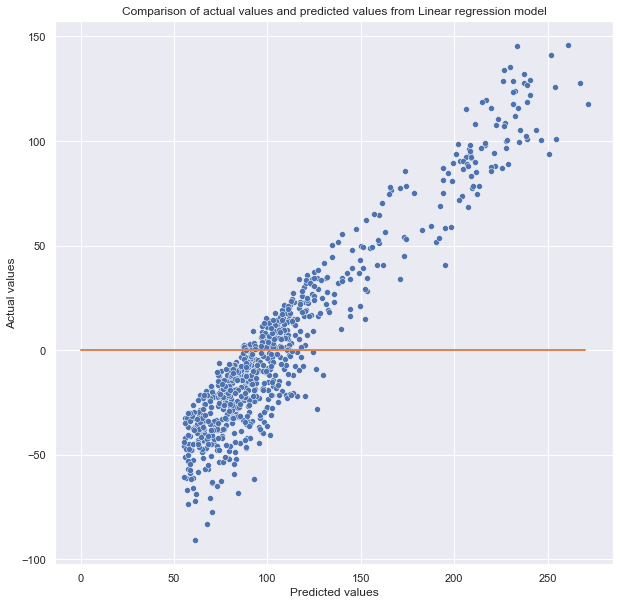

In [189]:
glucose_pipe.fit(train_set_glucose_val, train_glucose_val)

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(
    y=test_glucose_val - glucose_pipe.predict(test_set_glucose_val), x=test_glucose_val
)
plt.plot([0, 270], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Predicted values")
ax.set_ylabel("Actual values")
ax.set_title(
    "Comparison of actual values and predicted values from Linear regression model"
)
plt.show()

We can see that the residuals are all quite large.

In [441]:
categorical_features = (
    train_set_glucose.columns[train_set_glucose.dtypes == "object"]
    .drop("smoking_status")
    .tolist()
)
numeral_features = train_set_glucose.columns[~(train_set_glucose.dtypes == "object")]
column_names = np.concatenate(
    [
        glucose_transform.steps[2][1]
        .transformers_[0][1]["to_ordinal"]
        .feature_names_in_,
        glucose_transform.steps[2][1]
        .transformers_[1][1]
        .get_feature_names_out(categorical_features),
        numeral_features,
        ["missing_data", "avg_bmi_level"],
    ]
)

print(f"Intercept: {glucose_pipe[-1].intercept_:.3f}")
print("Coefficients:")
for name, coef in zip(column_names, glucose_pipe[-1].coef_):
    print(f" {name}: {coef:.4}")

Intercept: 73.759
Coefficients:
 smoking_status: 0.1185
 gender_Male: 3.484
 ever_married_Yes: 2.299
 work_type_Never_worked: 2.782
 work_type_Private: 1.797
 work_type_Self-employed: 1.125
 work_type_children: 10.33
 residence_type_Urban: -1.727
 age: 37.18
 hypertension: 16.71
 heart_disease: 18.8
 bmi: 69.82
 missing_data: -0.4773
 avg_bmi_level: -11.88


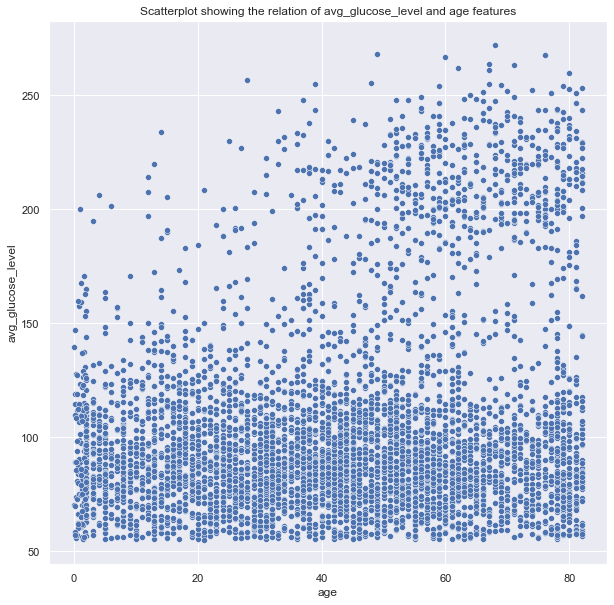

In [126]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x=data["age"], y=data["avg_glucose_level"])
plt.title("Scatterplot showing the relation of avg_glucose_level and age features")
plt.show()

Biggest correlations for avg_glucose_level column is with bmi and age. We saw that there is faint correlation with bmi in the previous section, and we can see a faint correlation here with age as well.

In [188]:
def objective_reg_bmi(trial, X: pd.DataFrame, y: pd.Series):

    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    eta0 = trial.suggest_float("eta", 1e-5, 0.1)
    epsilon = trial.suggest_float("epsilon", 1e-3, 0.2)
    alpha = trial.suggest_float("alpha", 1e-6, 1e-3)
    loss = trial.suggest_categorical(
        "loss", ["squared_error", "huber", "epsilon_insensitive"]
    )
    penalty = trial.suggest_categorical("penalty", ["l2", "l1"])
    learning_rate = trial.suggest_categorical(
        "learning_rate", ["optimal", "invscaling", "adaptive"]
    )

    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("fill_na_bmi", AgeGroupsMeanBmi()),
            ("categorical", categorical_pipeline),
            ("scaler", scaler),
            ("knn_imputer", KNNImputer()),
            (
                "sgd",
                SGDRegressor(
                    eta0=eta0,
                    epsilon=epsilon,
                    loss=loss,
                    penalty=penalty,
                    learning_rate=learning_rate,
                    alpha=alpha,
                    max_iter=2000,
                ),
            ),
        ]
    )

    models[trial.number] = pipe
    score = cross_val_score(pipe, X, y, n_jobs=-1, cv=5, scoring="r2")
    r2 = score.mean()
    return r2

In [ ]:
models = {}
glucose_1_wrapper = lambda trial: objective_reg_bmi(
    trial, train_set_glucose, train_glucose
)
optuna_glucose = optuna.create_study(direction="maximize")
optuna_glucose.optimize(glucose_1_wrapper, n_trials=300)

joblib.dump(optuna_glucose, "models//optuna_glucose.pkl")
best_optuna_glucose = models[optuna_glucose.best_trial.number]
joblib.dump(best_optuna_glucose, "models//best_optuna_glucose.pkl")

In [453]:
best_optuna_glucose = joblib.load("models//best_optuna_glucose.pkl")
optuna_glucose.best_trial.value

0.09876068421105003

We got a slightly better model by tuning the hyperparameters of the SGDRegressor algorithm. 

In [112]:
best_optuna_glucose.fit(train_set_glucose, train_glucose)
r2_score(test_glucose, best_optuna_glucose.predict(test_set_glucose))

0.07498612226228563

And the model is explaining only 7.5 % of the variance in the test set. Not a good model, but still better than just taking the mean.

In [115]:
joblib.dump(
    best_optuna_glucose, "models//trained_models//best_optuna_glucose_trained.pkl"
)

['models//trained_models//best_optuna_glucose_trained.pkl']

## Hypertension feature prediction

We'll predict the values for hypertension column next. It contains binary data, so we will be using classification algorithms.

In [190]:
hypertension_data = data.copy()
hypertension_data.drop("stroke", axis=1, inplace=True)

(
    train_set_hypertension,
    test_set_hypertension,
    train_hypertension,
    test_hypertension,
) = train_test_split(
    hypertension_data.loc[
        :, hypertension_data.columns[hypertension_data.columns != "hypertension"]
    ],
    hypertension_data["hypertension"],
    test_size=0.2,
    random_state=42,
    stratify=data["hypertension"],
)

In [191]:
models = [
    ["svm_rbf", SVC()],
    ["k_neighbors", KNeighborsClassifier()],
    ["logistic_reg", LogisticRegression()],
    ["decision_tree", DecisionTreeClassifier()],
    ["random_forest", RandomForestClassifier()],
    ["boosted_model", GradientBoostingClassifier()],
]
model_scores = pd.DataFrame(
    columns=[
        "f1_score",
        "recall",
        "precision",
        "average_precision",
        "model",
        "fit_time",
    ]
)

for index, model in enumerate(models):
    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("categorical", categorical_pipeline),
            ("scaler", MinMaxScaler()),
            ("knn_imputer", KNNImputer()),
            ("smote", SMOTE(random_state=11)),
            (model[0], model[1]),
        ]
    )
    temp = cross_validate(
        pipe,
        train_set_hypertension,
        train_hypertension,
        cv=5,
        scoring=("f1", "recall", "precision", "average_precision"),
    )
    model_scores.loc["default_" + model[0]] = [
        temp["test_f1"].mean(),
        temp["test_recall"].mean(),
        temp["test_precision"].mean(),
        temp["test_average_precision"].mean(),
        model[0],
        temp["fit_time"].mean(),
    ]

In [192]:
model_scores

,f1_score,recall,precision,average_precision,model,fit_time
default_svm_rbf,0.315054,0.696329,0.203856,0.240132,svm_rbf,1.926300
default_k_neighbors,0.267013,0.459873,0.188262,0.166292,k_neighbors,0.298997
default_logistic_reg,0.322105,0.751297,0.205037,0.282564,logistic_reg,0.343999
default_decision_tree,0.251788,0.361930,0.193469,0.132838,decision_tree,0.310198
default_random_forest,0.269554,0.321614,0.232949,0.227624,random_forest,1.044206
default_boosted_model,0.298935,0.573291,0.202331,0.249125,boosted_model,1.273805


Both f1 score and pr auc metric is best for logistic regression, so we will tune the hyperparameters for it to try and get an even better model.

In [233]:
def objective_hypertension(trial, X: pd.DataFrame, y: pd.Series):

    oversamplers = trial.suggest_categorical("oversampler", ["ROS", "SMOTE", "ADASYN"])
    if oversamplers == "ROS":
        oversampler = RandomOverSampler(sampling_strategy="minority")
    elif oversamplers == "SMOTE":
        oversampler = SMOTE(sampling_strategy="minority")
    else:
        oversampler = ADASYN(sampling_strategy="minority")

    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    c = trial.suggest_float("c", 1e-10, 1e3, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2", "none"])

    pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("categorical", categorical_pipeline),
            ("scaler", scaler),
            ("knn_imputer", KNNImputer()),
            ("oversampler", oversampler),
            ("log_reg", LogisticRegression(C=c, penalty=penalty)),
        ]
    )
    models[trial.number] = pipe

    score = cross_val_score(pipe, X, y, n_jobs=-1, cv=5, scoring="average_precision")
    pr_auc = score.mean()
    return pr_auc

In [ ]:
models = {}
hypertension_wrapper = lambda trial: objective_hypertension(
    trial, train_set_hypertension, train_hypertension
)
optuna_hypertension = optuna.create_study(direction="maximize")
optuna_hypertension.optimize(hypertension_wrapper, n_trials=300)

In [383]:
joblib.dump(optuna_hypertension, "models\\optuna_hypertension.pkl")
best_hypertension = models[optuna_hypertension_1.best_trial.number]
joblib.dump(best_hypertension, "models\\best_optuna_hypertension.pkl")

['models\\best_optuna_hypertension.pkl']

In [193]:
best_hypertension = joblib.load("models\\best_optuna_hypertension.pkl")

We get a model with a slightly better pr auc value.

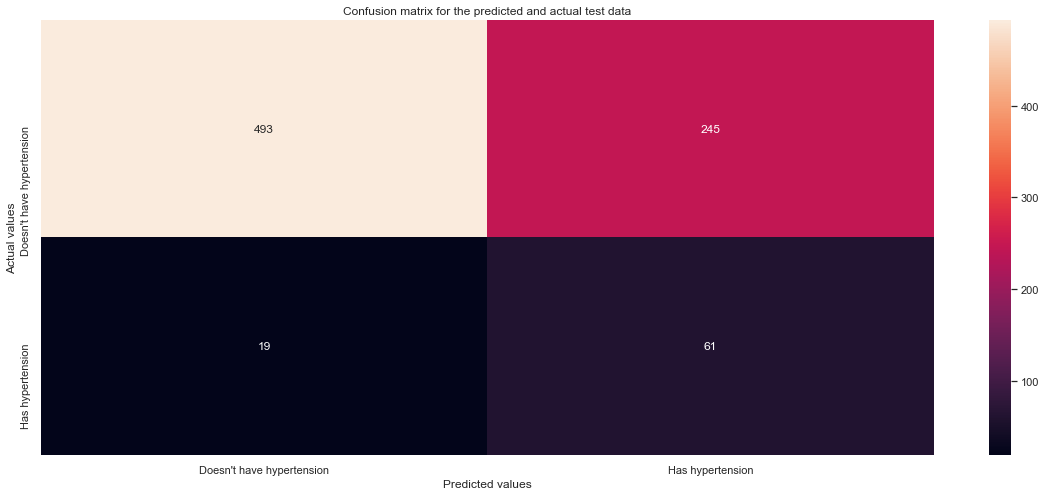

In [196]:
(
    train_set_hypertension_val,
    test_set_hypertension_val,
    train_hypertension_val,
    test_hypertension_val,
) = train_test_split(
    train_set_hypertension,
    train_hypertension,
    test_size=0.2,
    random_state=42,
    stratify=train_hypertension,
)

best_hypertension.fit(train_set_hypertension_val, train_hypertension_val)

matrix = confusion_matrix(
    test_hypertension_val, best_hypertension.predict(test_set_hypertension_val)
)
label_list = ["Doesn't have hypertension", "Has hypertension"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

We are again more interested in recall than anything else, since we are trying to predict a medical condition. The model with the current threshold does not have the best recall value, so let's try shifting the threshold.

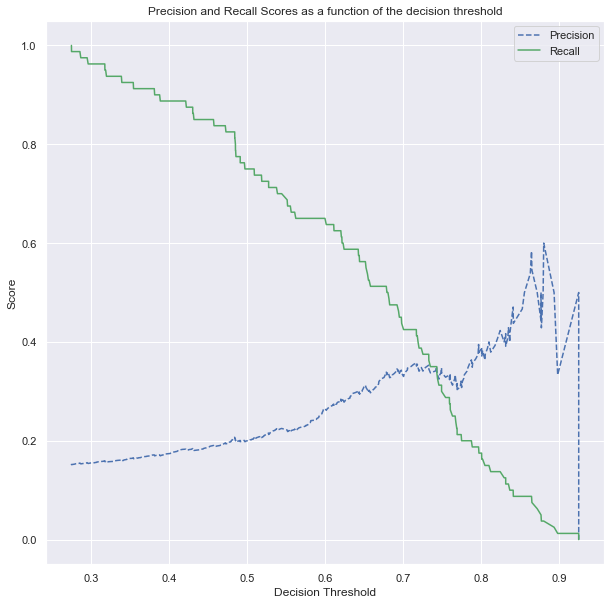

In [158]:
yhat = best_hypertension.predict_proba(test_set_hypertension_val)
yhat = yhat[:, 1]

precision, recall, thresholds = precision_recall_curve(test_hypertension_val, yhat)

plt.figure(figsize=(10, 10))
plt.title("Precision and Recall Scores as a function of the decision threshold")
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc="best")

In [206]:
hypertension_thresh = imb_pipeline(
    [
        ("missing_column", AddMissingColumn(missing_dict)),
        ("categorical", categorical_pipeline),
        ("scaler", best_hypertension[-4]),
        ("knn_imputer", KNNImputer()),
        ("oversampler", best_hypertension[-2]),
        ("model", Thresholder(best_hypertension[-1], 0.4)),
    ]
)

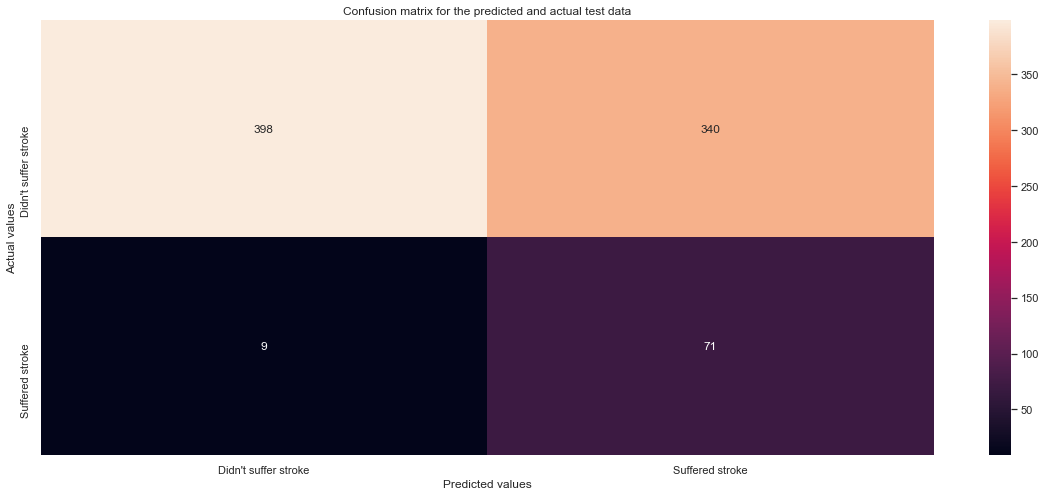

In [207]:
hypertension_thresh.fit(train_set_hypertension_val, train_hypertension_val)

matrix = confusion_matrix(
    test_hypertension_val, hypertension_thresh.predict(test_set_hypertension_val)
)
label_list = ["Didn't suffer stroke", "Suffered stroke"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

While with a threshold of 0.4 there are almost the same amount of false positives than true negatives, but at least we can be quite confident that the predicted negatives are actual negatives.

In [208]:
print(
    f"Recall: {recall_score(test_hypertension_val, hypertension_thresh.predict(test_set_hypertension_val))}"
)
print(
    f"Precision: {precision_score(test_hypertension_val, hypertension_thresh.predict(test_set_hypertension_val))}"
)

Recall: 0.8875
Precision: 0.17274939172749393


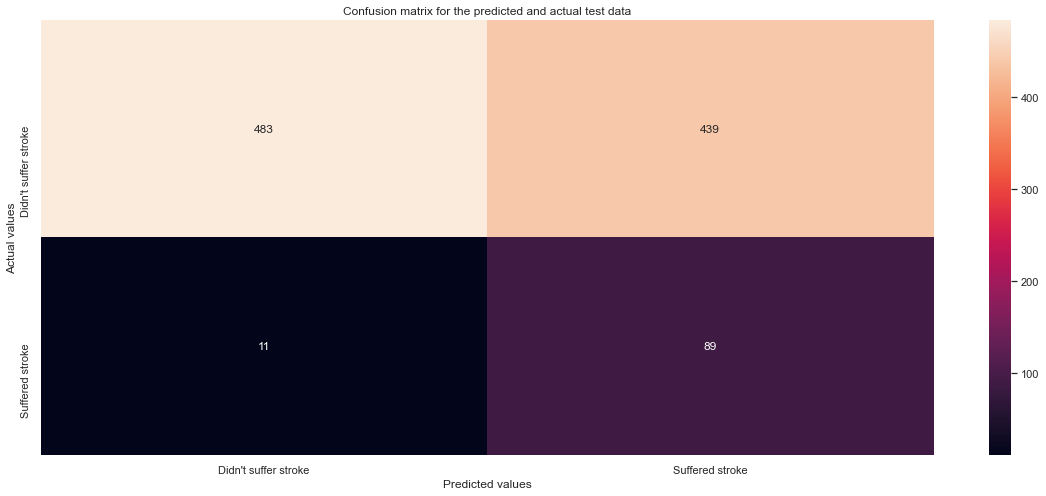

In [209]:
hypertension_thresh.fit(train_set_hypertension, train_hypertension)

matrix = confusion_matrix(
    test_hypertension, hypertension_thresh.predict(test_set_hypertension)
)
label_list = ["Didn't suffer stroke", "Suffered stroke"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

In [211]:
print(
    f"Recall: {recall_score(test_hypertension, hypertension_thresh.predict(test_set_hypertension))}"
)
print(
    f"Precision: {precision_score(test_hypertension, hypertension_thresh.predict(test_set_hypertension))}"
)

Recall: 0.89
Precision: 0.16856060606060605


The model performs equally well on the test data. 

In [123]:
joblib.dump(
    hypertension_thresh, "models\\trained_models\\best_optuna_hypertension_trained.pkl"
)

['models\\trained_models\\best_optuna_hypertension_trained.pkl']

## Combined models

Finally, we will train models to predict several of the features (bmi, avg_glucose_level, hypertension) in parallel. We will be using a seperate model for each feature. Since we already explored the features when we trained them for use seperately, we will automate the process now.

In [266]:
def train_model_regression(target_column: str, drop_columns: list, bmi: bool):
    """
    Trains and tunes the hyperparameters for a regression feature with a possibility to drop 
    columns that should be skipped in the training process.
    """
    temp_data = data.copy()
    temp_data.drop(drop_columns, axis=1, inplace=True)
    if target_column == "bmi":
        temp_data.dropna(axis=0, inplace=True)

    temp_set, temp_set_test, temp_target, temp_target_test = train_test_split(
        temp_data.loc[:, temp_data.columns[temp_data.columns != target_column]],
        temp_data[target_column],
        test_size=0.2,
        random_state=42,
    )
    model_scores = pd.DataFrame(
        columns=["r2", "fit_time", "scaler", "model_name", "model"]
    )

    models_list = [
        ["linear", LinearRegression()],
        ["ridge", Ridge()],
        ["lasso", Lasso()],
        ["sgd", SGDRegressor()],
    ]
    scalers = [
        ("MinMax", MinMaxScaler()),
        ("Standard", StandardScaler()),
        ("Robust", RobustScaler()),
    ]

    global missing_dict
    missing_dict = {"smoking_status": "Unknown"}
    if bmi:
        missing_dict = {"bmi": "nan", "smoking_status": "Unknown"}

    for scaler in scalers:
        for model in models_list:

            pipe = imb_pipeline(
                [
                    ("missing_column", AddMissingColumn(missing_dict)),
                    ("categorical", categorical_pipeline),
                    ("scaler", scaler[1]),
                    ("knn_imputer", KNNImputer()),
                    (model[0], model[1]),
                ]
            )
            pipe_bmi = imb_pipeline(
                [
                    ("missing_column", AddMissingColumn(missing_dict)),
                    ("fill_na_bmi", AgeGroupsMeanBmi()),
                    ("categorical", categorical_pipeline),
                    ("scaler", scaler[1]),
                    ("knn_imputer", KNNImputer()),
                    (model[0], model[1]),
                ]
            )

            if bmi:
                pipe = pipe_bmi
            temp = cross_validate(pipe, temp_set, temp_target, cv=5, scoring=("r2"))
            model_scores.loc[f"{model[0]}|{scaler[0]}"] = [
                temp["test_score"].mean(),
                temp["fit_time"].mean(),
                scaler[0],
                model[0],
                pipe,
            ]

        pipe = imb_pipeline(
            [
                ("missing_column", AddMissingColumn(missing_dict)),
                ("categorical", categorical_pipeline),
                ("scaler", scaler[1]),
                ("knn_imputer", KNNImputer()),
                ("poly_feat", PolynomialFeatures(degree=2)),
                ("linear", LinearRegression()),
            ]
        )
        pipe_bmi = imb_pipeline(
            [
                ("missing_column", AddMissingColumn(missing_dict)),
                ("fill_na_bmi", AgeGroupsMeanBmi()),
                ("categorical", categorical_pipeline),
                ("scaler", scaler[1]),
                ("knn_imputer", KNNImputer()),
                ("poly_feat", PolynomialFeatures(degree=2)),
                ("linear", LinearRegression()),
            ]
        )

        if bmi:
            pipe = pipe_bmi
        temp = cross_validate(pipe, temp_set, temp_target, cv=5, scoring=("r2"))
        model_scores.loc[f"polynomial|{scaler[0]}"] = [
            temp["test_score"].mean(),
            temp["fit_time"].mean(),
            scaler[0],
            model[0],
            pipe,
        ]

    temp_wrapper = lambda trial: objective_reg_no_bmi(trial, temp_set, temp_target)
    if bmi:
        temp_wrapper = lambda trial: objective_reg_bmi(trial, temp_set, temp_target)
    optuna_temp = optuna.create_study(direction="maximize")
    optuna_temp.optimize(temp_wrapper, n_trials=300)

    best_model = model_scores.loc[model_scores["r2"].idxmax(), "model"]
    if optuna_temp.best_trial.value > model_scores["r2"].max():
        best_model = models[optuna_temp.best_trial.number]
    best_model.fit(temp_set, temp_target)
    r2 = r2_score(temp_target_test, best_model.predict(temp_set_test))
    return [r2, 0, 0, best_model]

In [267]:
def train_model_classification(target_column: str, drop_columns: list, bmi: bool):
    """
    Trains and tunes the hyperparameters for a classification feature with a possibility to drop 
    columns that should be skipped in the training process.
    """
    temp_data = data.copy()
    temp_data.drop(drop_columns, axis=1, inplace=True)
    temp_set, temp_set_test, temp_target, temp_target_test = train_test_split(
        temp_data.loc[:, temp_data.columns[temp_data.columns != target_column]],
        temp_data[target_column],
        test_size=0.2,
        random_state=42,
        stratify=temp_data[target_column],
    )
    global missing_dict
    missing_dict = {"smoking_status": "Unknown"}
    if bmi:
        missing_dict = {"bmi": "nan", "smoking_status": "Unknown"}

    temp_wrapper = lambda trial: objective_hypertension(trial, temp_set, temp_target)
    optuna_temp = optuna.create_study(direction="maximize")
    optuna_temp.optimize(temp_wrapper, n_trials=300)
    temp_best_model = models[optuna_temp.best_trial.number]

    (
        temp_set_val,
        temp_set_test_val,
        temp_target_val,
        temp_target_test_val,
    ) = train_test_split(
        temp_set, temp_target, test_size=0.2, random_state=42, stratify=temp_target
    )
    temp_best_model.fit(temp_set_val, temp_target_val)

    temp_yhat = temp_best_model.predict_proba(temp_set_test_val)
    temp_yhat = temp_yhat[:, 1]
    temp_precision, temp_recall, temp_thresholds = precision_recall_curve(
        temp_target_test_val, temp_yhat
    )
    temp_thresh = temp_thresholds[np.where(temp_recall == 0.85)[0].min()]

    temp_pipe = imb_pipeline(
        [
            ("missing_column", AddMissingColumn(missing_dict)),
            ("categorical", categorical_pipeline),
            ("scaler", temp_best_model[-4]),
            ("knn_imputer", KNNImputer()),
            ("oversampler", temp_best_model[-2]),
            ("model", Thresholder(temp_best_model[-1], temp_thresh)),
        ]
    )

    temp_pipe.fit(temp_set, temp_target)
    recall = recall_score(temp_target_test, temp_pipe.predict(temp_set_test))
    precision = precision_score(temp_target_test, temp_pipe.predict(temp_set_test))
    return [0, recall, precision, temp_pipe]

In [268]:
model_details_list = [
    ["regression", "hg_glucose", "avg_glucose_level", ["stroke", "hypertension"], True],
    [
        "classification",
        "hg_hypertension",
        "hypertension",
        ["stroke", "avg_glucose_level"],
        True,
    ],
    ["regression", "hb_bmi", "bmi", ["stroke", "hypertension"], False],
    ["classification", "hb_hypertension", "hypertension", ["stroke", "bmi"], False],
    ["regression", "gb_glucose", "avg_glucose_level", ["stroke", "bmi"], False],
    ["regression", "gb_bmi", "bmi", ["stroke", "avg_glucose_level"], False],
    [
        "classification",
        "hgb_hypertension",
        "hypertension",
        ["stroke", "bmi", "avg_glucose_level"],
        False,
    ],
    [
        "regression",
        "hgb_glucose",
        "avg_glucose_level",
        ["stroke", "bmi", "hypertension"],
        False,
    ],
    [
        "regression",
        "hgb_bmi",
        "bmi",
        ["stroke", "avg_glucose_level", "hypertension"],
        False,
    ],
]

In [ ]:
model_result_list = pd.DataFrame(
    columns=["r2", "recall", "precision", "target_column", "model"]
)
for model_details in model_details_list:
    models = {}
    if model_details[0] == "regression":
        model_result = train_model_regression(
            model_details[2], model_details[3], model_details[4]
        )
        model_result_list.loc[model_details[1]] = [
            model_result[0],
            0,
            0,
            model_details[2],
            model_result[3],
        ]
    else:
        model_result = train_model_classification(
            model_details[2], model_details[3], model_details[4]
        )
        model_result_list.loc[model_details[1]] = [
            0,
            model_result[1],
            model_result[2],
            model_details[2],
            model_result[3],
        ]

In [270]:
model_result_list

,r2,recall,precision,target_column,model
hg_glucose,0.076465,0.00,0.000000,avg_glucose_level,"(AddMissingColumn(missing_dict={'bmi': 'nan', ..."
hg_hypertension,0.000000,0.83,0.178495,hypertension,"(AddMissingColumn(missing_dict={'bmi': 'nan', ..."
hb_bmi,0.253630,0.00,0.000000,bmi,(AddMissingColumn(missing_dict={'smoking_statu...
hb_hypertension,0.000000,0.77,0.187348,hypertension,(AddMissingColumn(missing_dict={'smoking_statu...
gb_glucose,0.053309,0.00,0.000000,avg_glucose_level,(AddMissingColumn(missing_dict={'smoking_statu...
gb_bmi,0.246961,0.00,0.000000,bmi,(AddMissingColumn(missing_dict={'smoking_statu...
hgb_hypertension,0.000000,0.79,0.186761,hypertension,(AddMissingColumn(missing_dict={'smoking_statu...
hgb_glucose,0.060140,0.00,0.000000,avg_glucose_level,(AddMissingColumn(missing_dict={'smoking_statu...
hgb_bmi,0.236423,0.00,0.000000,bmi,(AddMissingColumn(missing_dict={'smoking_statu...


We can see that we actually got a slightly better model for hb_bmi than we did for bmi seperately. Same with hg_glucose. Interesting thing to notice is that both avg_glucose_level and bmi got better models in cases where the other was included in the train data - as we noticed previously, for both features one of the largest correlations were with each other.

In [288]:
for index in range(9):
    joblib.dump(
        model_result_list.iloc[index]["model"],
        f"models\\trained_models\\best_{model_result_list.iloc[index].name}_trained.pkl",
    )

## Conclusions

The original idea was to create a model that could, by itself, with confidence predict whether or not someone is going to suffer a stroke. After seeing the large amounts of false positives from even te best of my models, the whole concept shifted to creating a model that should be used either as a helper for the doctors to eliminate obvious true negatives and thus letting them give more attention to the patients that are actually at risk, or as a awareness raising tool for general public to check whether they might be at risk, and in case of getting a positive answer, scheduling a check up with an actual doctor. Similar case with the models predicting hypertension - as a helper or awareness raising tool. As for the glucose level and bmi, the models, I think, turned out too bad to really be usable.